In [27]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import torch
import math
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy, skew, truncnorm
from matplotlib import gridspec
import utils

In [28]:
model_type = 'swmag'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
dbht_results_dir = 'outputs/dbht_max'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['CEU-2', 'GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [55]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])
		results[key]['mlt_station'] = region['mlt_station']
		if key == 'ALSK' or key == 'HUD-1':
			continue

		if key in list_of_oversampled_regions:
			results[key]['swmag_rsd'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_alt_v4_oversampling.feather')
			results[key]['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{key}_version_swmag_alt_v4_dbht_oversampling.feather')
			results[key]['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_v4_oversampling.feather')
			results[key]['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{key}_version_twins_alt_v4_dbht_oversampling.feather')

		else:
			results[key]['swmag_rsd'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_alt_v4.feather')
			results[key]['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{key}_version_swmag_alt_v4_dbht.feather')
			results[key]['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_v4.feather')
			results[key]['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{key}_version_twins_alt_v4_dbht.feather')

results['HUD-1']['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_HUD-1_version_swmag_alt_v4_dbht_oversampling.feather')
results['HUD-1']['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_HUD-1_version_swmag_alt_v4_oversampling.feather')
results['HUD-1']['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_HUD-1_version_twins_alt_v4.feather')
results['HUD-1']['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_HUD-1_version_twins_alt_v4_dbht.feather')
results['ALSK']['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_ALSK_version_swmag_alt_v4_dbht_oversampling.feather')
results['ALSK']['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_ALSK_version_swmag_alt_v4_oversampling.feather')
results['ALSK']['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_ALSK_version_twins_alt_v4.feather')
results['ALSK']['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_ALSK_version_twins_alt_v4_dbht.feather')


Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [4]:
# date_range = pd.date_range('2009-07-20', '2017-12-31', freq='min')

# temp_df = results['CAN-2']['twins_dbht'].set_index('dates', drop=True, inplace=False)
# # temp_df = results['CEU-2']['alt_v4_results']
# plotting_df = pd.DataFrame(index=date_range)
# plotting_df = plotting_df.join(temp_df, how='left')
# # start = '2010-01-01'
# # end = '2017-12-31'
# start = '2013-06-01'
# end = '2013-06-30'
# fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# axes.plot(plotting_df[start:end].index, plotting_df['predicted_mean'][start:end], linewidth=4)
# axes.plot(plotting_df[start:end].index, plotting_df['actual'][start:end], linewidth=4)

# # temp_df = results['FSC-4']['twins_results'].set_index('dates', drop=True, inplace=False)
# # plotting_df = pd.DataFrame(index=date_range)
# # plotting_df = plotting_df.join(temp_df, how='left')
# # axes.plot(plotting_df.index, plotting_df['actual'], linewidth=4)
# plt.show()

In [5]:
	roc = roc_curve(y_true=results['FSC-4']['twins_rsd']['actual'], y_score=results['FSC-4']['twins_rsd']['predicted_mean'])
	prec, rec, __ = precision_recall_curve(y_true=results['FSC-4']['twins_rsd']['actual'], probas_pred=results['FSC-4']['twins_rsd']['predicted_mean'])
	pr_auc = auc(rec, prec)
	print(f'TWINS ROC: {auc(roc[0], roc[1])}')
	print(f'TWINS PR AUC: {pr_auc}')

	roc = roc_curve(y_true=results['FSC-4']['swmag_rsd']['actual'], y_score=results['FSC-4']['swmag_rsd']['predicted_mean'])
	prec, rec, __ = precision_recall_curve(y_true=results['FSC-4']['swmag_rsd']['actual'], probas_pred=results['FSC-4']['swmag_rsd']['predicted_mean'])
	pr_auc = auc(rec, prec)
	print(f'SWMAG ROC: {auc(roc[0], roc[1])}')
	print(f'SWMAG PR AUC: {pr_auc}')

TWINS ROC: 0.9465976742867519
TWINS PR AUC: 0.8812276425208128
SWMAG ROC: 0.9380669432152302
SWMAG PR AUC: 0.8215719949778038


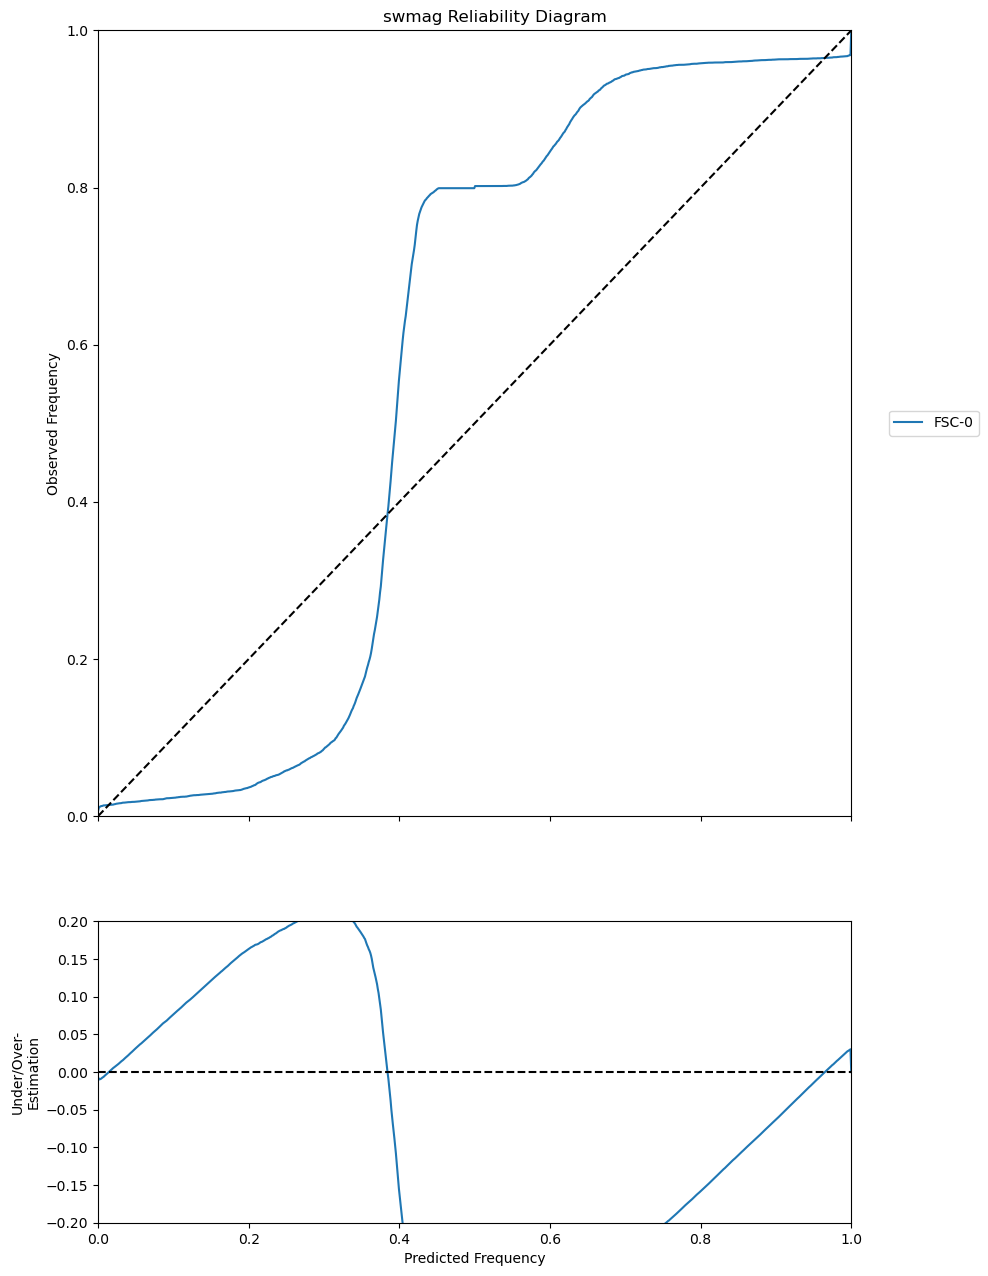

In [6]:

def plotting_continuious_reliability_diagram(results, region, model, target):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	predictions = results[region][f'{model}_{target}'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
	actual = predictions['actual']
	predicted_mean = predictions['predicted_mean']
	predicted_std = predictions['predicted_std']

	standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
	cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
	for i in standard_error.index:
		cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

	ax[0].plot(x, cumulative_dist[:,0], label=region)
	ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

	return x, cumulative_dist[:,0]

reg = 'FSC-0'
model = 'swmag'
target = 'rsd'
x, y = plotting_continuious_reliability_diagram(results, reg, model, target)

In [7]:
# def get_std_mean(predictions, x, y):

# 	above, below, mean, std, count = [], [], [], [], []

# 	for i in range(len(x)-1):
# 		x_segmented = predictions.loc[(predictions['predicted_mean'] >= x[i]) & (predictions['predicted_mean'] < x[i+1])]
# 		mean.append(np.mean(x_segmented['predicted_std']))
# 		std.append(np.std(x_segmented['predicted_std']))
# 		count.append(len(x_segmented))
# 		above = above + x_segmented.loc[x_segmented['predicted_std'] >= y[i]]['predicted_std'].tolist()
# 		below = below + x_segmented.loc[x_segmented['predicted_std'] < y[i]]['predicted_std'].tolist()

# 	return np.round(np.mean(above),3), np.round(np.median(above),3), np.round(np.std(above),3), \
# 			np.round(np.mean(below),3), np.round(np.median(below),3), np.round(np.std(below),3), \
# 				mean, std, count

# def plotting_scatter(results, region, model, target, lower_pred=None, upper_pred=None, split=False, x=None, y=None, lower_mean_bound=None, upper_mean_bound=None):

# 	if lower_pred is None and upper_pred is not None:
# 		raise ValueError('If you specify an upper bound, you must also specify a lower bound.')
# 	if lower_pred is not None and upper_pred is None:
# 		raise ValueError('If you specify a lower bound, you must also specify an upper bound.')

# 	if not split:
# 		fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(17,10))
# 	else:
# 		fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(19,10))

# 	predictions = results[region][f'{model}_{target}'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
	
# 	if lower_pred is not None and upper_pred is not None:
# 		plotting = predictions.loc[(predictions['predicted_mean'] > lower_pred) & (predictions['predicted_mean'] < upper_pred)]
# 	else:
# 		plotting = predictions

# 	if upper_mean_bound is None:
# 		upper_mean_bound = (1-lower_mean_bound)

# 	if lower_mean_bound is not None:
# 		plotting = plotting.loc[plotting['predicted_mean'] > lower_mean_bound]
# 		plotting = plotting.loc[plotting['predicted_mean'] < upper_mean_bound]

# 	if split:
# 		plotting_0 = plotting.loc[plotting['actual'] == 0]
# 		plotting_1 = plotting.loc[plotting['actual'] == 1]
# 		axes[0].scatter(plotting_0['predicted_mean'], plotting_0['predicted_std'], s=1, color='blue')
# 		axes[1].scatter(plotting_1['predicted_mean'], plotting_1['predicted_std'], s=1, color='red')
# 		axes[0].set_title(f'{model.upper()} Predictions for {region} Class False')
# 		axes[1].set_title(f'{model.upper()} Predictions for {region} Class True')
# 		axes[0].plot([0,1], [0,1], color='black', linestyle='--', label='StD = Mean Line')
# 		axes[1].plot([0,1], [0,1], color='black', linestyle='--', label='StD = Mean Line')
# 		if x is not None and y is not None:
# 			above0mean, above0median, above0std, below0mean, below0median, below0stsd = get_std_mean(plotting_0, x, y)
# 			above1mean, above1median, above1std, below1mean, below1median, below1stsd = get_std_mean(plotting_1, x, y)
# 			axes[0].plot(x, y, color='black', label='Reliability Line')
# 			axes[1].plot(x, y, color='black', label='Reliability Line')
# 			axes[0].annotate(f'Right Side Mean: {below0mean}', xy=(0, 0), xytext=(0.5, plotting_0['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[0].annotate(f'Right Side Median: {below0median}', xy=(0, 0), xytext=(0.5, plotting_0['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[0].annotate(f'Right Side Std: {below0std}', xy=(0, 0), xytext=(0.5, plotting_0['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes[0].annotate(f'Left Side Mean: {above0mean}', xy=(1, 0), xytext=(0, plotting_0['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[0].annotate(f'Left Side Median: {above0median}', xy=(1, 0), xytext=(0, plotting_0['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[0].annotate(f'Left Side Std: {above0std}', xy=(1, 0), xytext=(0, plotting_0['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes[1].annotate(f'Right Side Mean: {below1mean}', xy=(0, 0), xytext=(0.5, plotting_1['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[1].annotate(f'Right Side Median: {below1median}', xy=(0, 0), xytext=(0.5, plotting_1['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[1].annotate(f'Right Side Std: {below1stsd}', xy=(0, 0), xytext=(0.5, plotting_1['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes[1].annotate(f'Left Side Mean: {above1mean}', xy=(1, 0), xytext=(0, plotting_1['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[1].annotate(f'Left Side Median: {above1median}', xy=(1, 0), xytext=(0, plotting_1['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[1].annotate(f'Left Side Std: {above1std}', xy=(1, 0), xytext=(0, plotting_1['predicted_std'].max()+0.15), textcoords='axes fraction')
# 		axes[0].set_ylim(0,plotting['predicted_std'].max()+0.05)
# 		axes[1].set_ylim(0,plotting['predicted_std'].max()+0.05)
# 		axes[0].set_xlabel('Predicted Mean')
# 		axes[1].set_xlabel('Predicted Mean')
# 		axes[0].set_ylabel('Predicted Std')
# 		axes[1].set_ylabel('Predicted Std')
# 		axes[0].legend(loc='lower center')
# 		axes[1].legend(loc='lower center')
# 		plt.show()

# 	else:
# 		axes.scatter(plotting['predicted_mean'], plotting['predicted_std'], s=1)
# 		axes.plot([0,1], [0,1], color='black', linestyle='--', label='StD = Mean Line')
# 		if x is not None and y is not None:
# 			axes.plot(x, y, color='black', label='Reliability Line')
# 			abovemean, abovemedian, abovestd, belowmean, belowmedian, belowstd, mean, std, count = get_std_mean(plotting, x, y)
# 			count = count/np.max(count)
# 			# axes.plot(x[:-1], mean, color='red', label='Mean of Std')
# 			axes.plot(x[:-1], std, color='green', label='Std of Std')
# 			# axes.plot(x[:-1], count, color='purple', label='Count')
# 			axes.annotate(f'Right Side Mean: {belowmean}', xy=(0, 0), xytext=(0.8, plotting['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes.annotate(f'Right Side Median: {belowmedian}', xy=(0, 0), xytext=(0.8, plotting['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes.annotate(f'Right Side Std: {belowstd}', xy=(0, 0), xytext=(0.8, plotting['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes.annotate(f'Left Side Mean: {abovemean}', xy=(1, 0), xytext=(0, plotting['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes.annotate(f'Left Side Median: {abovemedian}', xy=(1, 0), xytext=(0, plotting['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes.annotate(f'Left Side Std: {abovestd}', xy=(1, 0), xytext=(0, plotting['predicted_std'].max()+0.15), textcoords='axes fraction')
# 		axes.set_ylim(0,plotting['predicted_std'].max()+0.05)
# 		axes.set_xlabel('Predicted Mean')
# 		axes.set_ylabel('Predicted Std')
# 		axes.set_title(f'{model.upper()} Predictions for {region}')
# 		axes.legend(loc='center left')
# 		plt.show()

# reg = 'GRL-0'
# model = 'twins'
# target = 'rsd'

# x, y = plotting_continuious_reliability_diagram(results, reg, model, target=target)
# plotting_scatter(results=results, region=reg, model=model, target=target, lower_pred=None, upper_pred=None, split=False, x=x, y=y, lower_mean_bound=0.0, upper_mean_bound=None)

# # getting the mean of the std values on either side of the reliability line



In [8]:
# def plotting_examples(results, region, model, upper_pred, lower_pred):

# 	''' Function that plots the reliability diagram for the predictions.'''

# 	fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(13,10))

# 	# if model == 'dbht':
# 	predictions = results[region][f'{model}'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
# 	# else:
# 	# 	predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
	
# 	plotting = predictions.loc[(predictions['predicted_mean'] > lower_pred) & (predictions['predicted_mean'] < upper_pred)]
# 	plotting.reset_index(inplace=True, drop=True)

# 	plotting['fill_bottom'] = plotting['predicted_mean'] - plotting['predicted_std']
# 	plotting['fill_top'] = plotting['predicted_mean'] + plotting['predicted_std']
# 	# plotting.clip(lower=0, upper=1, inplace=True)
# 	plotting['bottom'] = plotting['actual']*1.00
# 	plotting['top'] = plotting['actual']*1.03
# 	print(plotting.head())
# 	# creates an array from the y_bar dataframe
# 	z1=np.array(plotting['bottom'])
# 	# creates another array. These two arrays are compared to create the bar at the top of the plots.
# 	z2=np.array(plotting['top'])

# 	axes.plot(plotting['predicted_mean'], color='blue')
# 	axes.fill_between(plotting.index, plotting['fill_bottom'], plotting['fill_top'], color='blue', alpha=0.2)
# 	axes.fill_between(plotting.index, plotting['bottom'], plotting['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
# 	axes.set_ylabel('Probability')
# 	axes.set_title(f'Predicted Probability for Region {region} with 1$\sigma$ error bars between prob {lower_pred} and {upper_pred}')
# 	axes.set_xlabel('Time')
# 	axes.legend()
# 	plt.show()

# plotting_examples(results=results, region='GRL-0', model='alt_v4', lower_pred=0.9, upper_pred=1.0)


In [37]:
class MetricResults():

	def __init__(self, n_samples=1000):
		
		self.n_samples = n_samples
	
	def getting_mean_predictions(self):

		''' Function that gets the mean predictions for each station. '''

		if self.metric == 'prauc':
			self.mean_metric = self.calibrating_prauc(y_true=self.df['actual'], y_pred=self.df['predicted_mean'])
		elif self.metric == 'roc':
			roc = roc_curve(y_true=self.df['actual'], y_score=self.df['predicted_mean'])
			self.mean_metric = auc(roc[0], roc[1])
		elif self.metric == 'brier':
			self.mean_metric = brier_score_loss(y_true=self.df['actual'], y_prob=self.df['predicted_mean'])
		elif self.metric == 'rmse':
			self.mean_metric = np.sqrt(mean_squared_error(y_true=self.df['actual'], y_pred=self.df['predicted_mean']))
		else:
			raise ValueError('Invalid metric. Choose from prauc, roc, brier, rmse')


	def calibrating_prauc(self, y_true, y_pred):

		prec, rec, __ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
		prauc = auc(rec, prec)
		ds_skew = np.sum(y_true)/len(y_true)

		aucmin = (1+((1-ds_skew)*np.log(1-ds_skew)/ds_skew))

		cal_auc = (prauc - aucmin)/(1 - aucmin)
		
		return cal_auc

	def gaussian_samples(self):

		''' Function that gets the gaussian samples for the predictions. '''

		samples = truncnorm.rvs(-1, 1, loc=self.df['predicted_mean'], scale=self.df['predicted_std'], size=(self.n_samples, len(self.df['predicted_mean'])))
		
		# taking samples above 1 and below 0 and moving them to the other side
		samples = np.abs(samples)
		samples = np.where(samples > 1, 2 - samples, samples)

		return samples

	def plotting_samples_around_mean(self):
		
		''' Function that plots the samples around the mean. '''
		plotting_lower = 2725
		plotting_upper = 2850
		samples = self.gaussian_samples()
		fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(13,10))

		for i in range(self.n_samples):
			axes.plot(samples[i,plotting_lower:plotting_upper], color='blue', alpha=0.1)

		axes.plot([j for j in range(0,plotting_upper-plotting_lower)], self.df['predicted_mean'][plotting_lower:plotting_upper], color='red', linewidth=2)
		axes.fill_between([j for j in range(0,plotting_upper-plotting_lower)], self.df['predicted_mean'][plotting_lower:plotting_upper] - self.df['predicted_std'][plotting_lower:plotting_upper], self.df['predicted_mean'][plotting_lower:plotting_upper] + self.df['predicted_std'][plotting_lower:plotting_upper], color='red', alpha=0.2)
		axes.set_ylabel('Probability')
		axes.set_title(f'Sampled Probability for with 1$\sigma$ error bars')
		axes.set_xlabel('Time')
		plt.show()

	def sampled_metric_scores(self):

		''' Function that gets the metric scores for the gaussian samples. '''

		samples = self.gaussian_samples()
		metric_scores = []

		for i in range(self.n_samples):
			if self.metric == 'prauc':
				metric_scores.append(self.calibrating_prauc(y_true=self.df['actual'], y_pred=samples[i]))
			elif self.metric == 'roc':
				roc = roc_curve(y_true=self.df['actual'], y_score=samples[i])
				metric_scores.append(auc(roc[0], roc[1]))
			elif self.metric == 'brier':
				metric_scores.append(brier_score_loss(y_true=self.df['actual'], y_prob=samples[i]))
			elif self.metric == 'rmse':
				metric_scores.append(np.sqrt(mean_squared_error(y_true=self.df['actual'], y_pred=samples[i])))
			else:
				raise ValueError('Invalid metric. Choose from prauc, roc, brier, rmse')
		
		return metric_scores

	def __call__(self, df, metric='prauc'):
		
		self.df = df
		self.metric = metric

		''' Function that returns the mean and std of the metric scores. '''
		self.getting_mean_predictions()
		samples = self.sampled_metric_scores()

		# calculating the mean squared error of the samples
		metric_error = np.std(samples)
		# metric_error = mean_squared_error(np.array([self.mean_metric for i in range(self.n_samples)]), samples)

		return self.mean_metric, metric_error


In [38]:
def calibrating_prauc(y_true, y_pred):

	prec, rec, __ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
	prauc = auc(rec, prec)
	ds_skew = np.sum(y_true)/len(y_true)

	aucmin = (1+((1-ds_skew)*np.log(1-ds_skew)/ds_skew))

	cal_auc = (prauc - aucmin)/(1 - aucmin)
	
	return cal_auc

In [40]:
swmag_rsd_auc, twins_rsd_auc, swmag_dbht_auc, twins_dbht_auc, swmag_rsd_roc, twins_rsd_roc, swmag_dbht_roc, twins_dbht_roc, mean_lat, reg_names = [], [], [], [], [], [], [], [], [], []
swmag_rsd_error, twins_rsd_error, swmag_dbht_error, twins_dbht_error = [], [], [], []

metric_results = MetricResults(n_samples=1000)

for key in results.keys():
	roc = roc_curve(y_true=results[key]['swmag_rsd']['actual'], y_score=results[key]['swmag_rsd']['predicted_mean'])
	swmag_rsd_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['twins_rsd']['actual'], y_score=results[key]['twins_rsd']['predicted_mean'])
	twins_rsd_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['swmag_dbht']['actual'], y_score=results[key]['swmag_dbht']['predicted_mean'])
	swmag_dbht_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['twins_dbht']['actual'], y_score=results[key]['twins_dbht']['predicted_mean'])
	twins_dbht_roc.append(auc(roc[0], roc[1]))
	
	# swmag_rsd_auc.append(metric_results(df=results[key]['swmag_rsd'], metric='prauc'))
	# twins_rsd_auc.append(metric_results(df=results[key]['twins_rsd'], metric='prauc'))
	# swmag_dbht_auc.append(metric_results(df=results[key]['swmag_dbht'], metric='prauc'))
	# twins_dbht_auc.append(metric_results(df=results[key]['twins_dbht'], metric='prauc'))

	swmag_rsd_auc.append(calibrating_prauc(y_true=results[key]['swmag_rsd']['actual'], y_pred=results[key]['swmag_rsd']['predicted_mean']))
	swmag_dbht_auc.append(calibrating_prauc(y_true=results[key]['swmag_dbht']['actual'], y_pred=results[key]['swmag_dbht']['predicted_mean']))
	twins_rsd_auc.append(calibrating_prauc(y_true=results[key]['twins_rsd']['actual'], y_pred=results[key]['twins_rsd']['predicted_mean']))
	twins_dbht_auc.append(calibrating_prauc(y_true=results[key]['twins_dbht']['actual'], y_pred=results[key]['twins_dbht']['predicted_mean']))

	mean_lat.append(results[key]['mean_lat'])
	reg_names.append(key)

# swmag_rsd_auc, swmag_rsd_error = zip(*swmag_rsd_auc)
# twins_rsd_auc, twins_rsd_error = zip(*twins_rsd_auc)
# swmag_dbht_auc, swmag_dbht_error = zip(*swmag_dbht_auc)
# twins_dbht_auc, twins_dbht_error = zip(*twins_dbht_auc)


In [42]:
# swmag_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_rsd_auc':swmag_rsd_auc, 'swmag_rsd_roc':swmag_rsd_roc,
# 									'auc_error':swmag_rsd_error, 'region':reg_names})
# twins_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_rsd_auc':twins_rsd_auc, 'twins_rsd_roc':twins_rsd_roc, 
# 									'auc_error':twins_rsd_error, 'region':reg_names})
# swmag_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_dbht_auc':swmag_dbht_auc, 'swmag_dbht_roc':swmag_dbht_roc,
# 									'auc_error':swmag_dbht_error, 'region':reg_names})
# twins_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_dbht_auc':twins_dbht_auc, 'twins_dbht_roc':twins_dbht_roc,
# 									'auc_error':twins_dbht_error, 'region':reg_names})
swmag_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_rsd_auc':swmag_rsd_auc, 'swmag_rsd_roc':swmag_rsd_roc, 'region':reg_names})
twins_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_rsd_auc':twins_rsd_auc, 'twins_rsd_roc':twins_rsd_roc, 'region':reg_names})
swmag_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_dbht_auc':swmag_dbht_auc, 'swmag_dbht_roc':swmag_dbht_roc, 'region':reg_names})
twins_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_dbht_auc':twins_dbht_auc, 'twins_dbht_roc':twins_dbht_roc, 'region':reg_names})

swmag_rsd_plot_df.sort_values(by='mean_lat', inplace=True)
twins_rsd_plot_df.sort_values(by='mean_lat', inplace=True)
swmag_dbht_plot_df.sort_values(by='mean_lat', inplace=True)
twins_dbht_plot_df.sort_values(by='mean_lat', inplace=True)

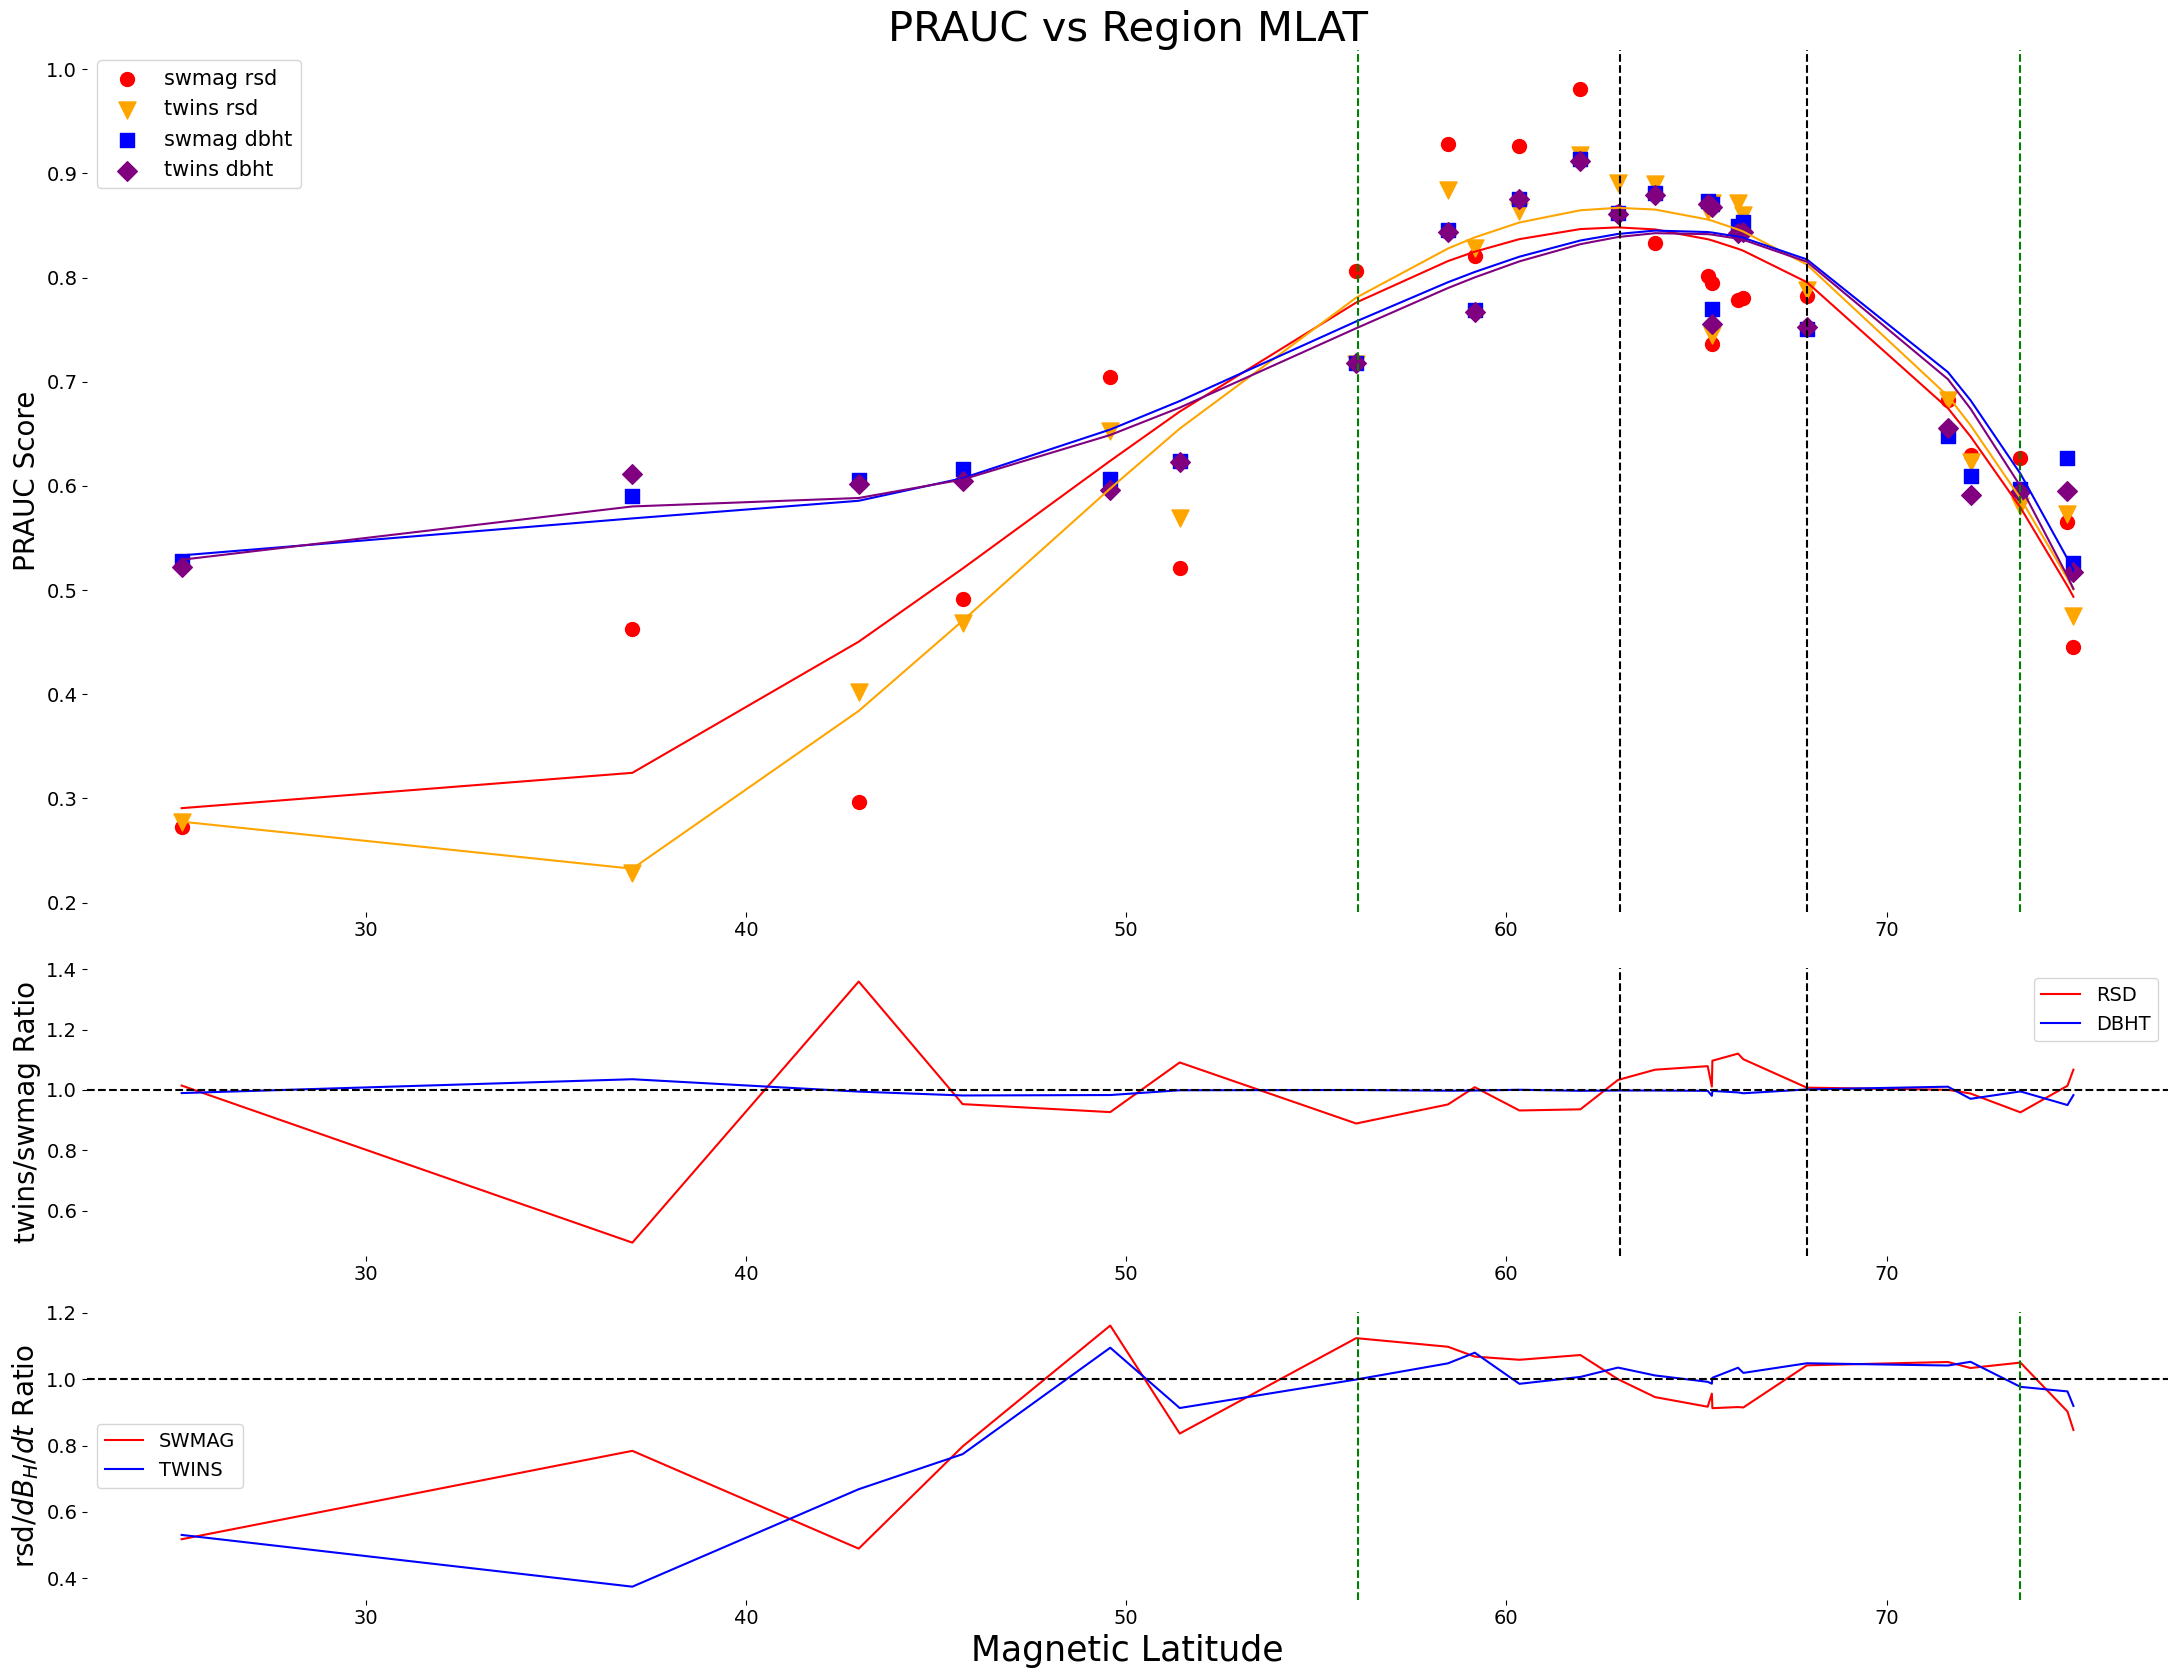

In [73]:
fig = plt.figure(figsize=(22,17))
gs = fig.add_gridspec(3,1, height_ratios=[3,1,1])
# fig, axes = plt.subplots(ncols=1, nrows=2, sharex=False, figsize=(13,8), gridspec_kw={'height_ratios': [2,1]})
axes0 = fig.add_subplot(gs[0])
axes1 = fig.add_subplot(gs[1])
axes2 = fig.add_subplot(gs[2])

axes0.scatter(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], label='swmag rsd', color='red', marker='o', s=100)
# axes0.errorbar(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], yerr=swmag_rsd_plot_df['auc_error'], fmt='o', color='red')
axes0.scatter(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc'], label='twins rsd', color='orange', marker='v', s=150)
# axes0.errorbar(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc'], yerr=twins_rsd_plot_df['auc_error'], fmt='v', color='orange')
axes0.scatter(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], label='swmag dbht', color='blue', marker='s', s=100)
# axes0.errorbar(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], yerr=swmag_dbht_plot_df['auc_error'], fmt='s', color='blue')
axes0.scatter(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc'], label='twins dbht', color='purple', marker='D', s=100)
# axes0.errorbar(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc'], yerr=twins_dbht_plot_df['auc_error'], fmt='D', color='purple')

swmag_rsd_z = np.polyfit(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], 4)
swmag_rsd_p = np.poly1d(swmag_rsd_z)
twins_rsd_z = np.polyfit(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc'], 4)
twins_rsd_p = np.poly1d(twins_rsd_z)
swmag_dbht_z = np.polyfit(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], 4)
swmag_dbht_p = np.poly1d(swmag_dbht_z)
twins_dbht_z = np.polyfit(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc'], 4)
twins_dbht_p = np.poly1d(twins_dbht_z)

axes0.plot(swmag_rsd_plot_df['mean_lat'], swmag_rsd_p(swmag_rsd_plot_df['mean_lat']), color='red')
axes0.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_p(twins_rsd_plot_df['mean_lat']), color='orange')
axes0.plot(swmag_dbht_plot_df['mean_lat'], swmag_dbht_p(swmag_dbht_plot_df['mean_lat']), color='blue')
axes0.plot(twins_dbht_plot_df['mean_lat'], twins_dbht_p(twins_dbht_plot_df['mean_lat']), color='purple')
axes0.axvline(63, color='black', linestyle='--')
axes0.axvline(67.9, color='black', linestyle='--')
axes0.axvline(56.1, color='green', linestyle='--')
axes0.axvline(73.5, color='green', linestyle='--')

axes0.set_ylabel('PRAUC Score', fontsize=20)
axes0.set_title('PRAUC vs Region MLAT', fontsize=30)
axes0.legend(loc='upper left', fontsize=15)

axes1.set_ylabel('twins/swmag Ratio', fontsize=20)
axes1.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc']/swmag_rsd_plot_df['swmag_rsd_auc'], label='RSD', color='red')
axes1.plot(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc']/swmag_dbht_plot_df['swmag_dbht_auc'], label='DBHT', color='blue')
axes1.axvline(63, color='black', linestyle='--')
axes1.axvline(67.9, color='black', linestyle='--')
axes1.axhline(1, color='black', linestyle='--')
axes1.legend()
plt.subplots_adjust(hspace = -0.20)

axes2.set_ylabel(r'rsd/$dB_H/dt$ Ratio', fontsize=20)
axes2.plot(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc']/swmag_dbht_plot_df['swmag_dbht_auc'], label='SWMAG', color='red')
axes2.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc']/twins_dbht_plot_df['twins_dbht_auc'], label='TWINS', color='blue')
axes2.axvline(56.1, color='green', linestyle='--')
axes2.axvline(73.5, color='green', linestyle='--')
axes2.axhline(1, color='black', linestyle='--')
axes2.set_xlabel('Magnetic Latitude', fontsize=25)
axes2.legend()

plt.tight_layout()
plt.savefig(f'plots/pr-auc_vs_region_mlat.png', bbox_inches='tight')

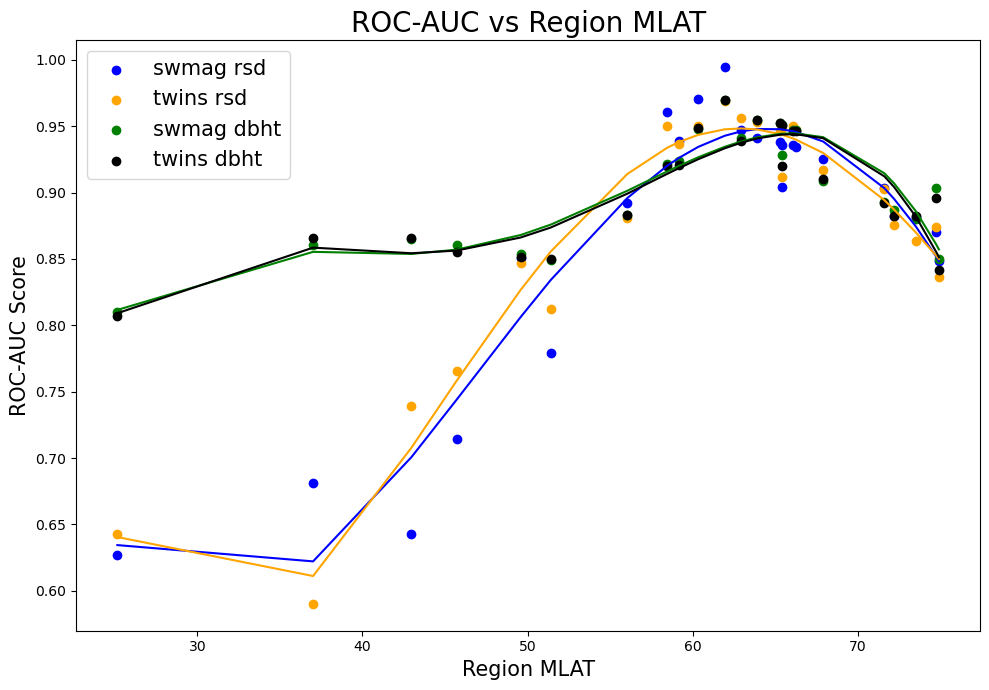

In [44]:
fig, axes = plt.subplots(1,1,figsize=(10,7))
axes.scatter(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_roc'], label='swmag rsd', color='blue')
axes.scatter(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_roc'], label='twins rsd', color='orange')
axes.scatter(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_roc'], label='swmag dbht', color='green')
axes.scatter(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_roc'], label='twins dbht', color='black')

swmag_rsd_z = np.polyfit(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_roc'], 4)
swmag_rsd_p = np.poly1d(swmag_rsd_z)
twins_rsd_z = np.polyfit(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_roc'], 4)
twins_rsd_p = np.poly1d(twins_rsd_z)
swmag_dbht_z = np.polyfit(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_roc'], 4)
swmag_dbht_p = np.poly1d(swmag_dbht_z)
twins_dbht_z = np.polyfit(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_roc'], 4)
twins_dbht_p = np.poly1d(twins_dbht_z)

axes.plot(swmag_rsd_plot_df['mean_lat'], swmag_rsd_p(swmag_rsd_plot_df['mean_lat']), color='blue')
axes.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_p(twins_rsd_plot_df['mean_lat']), color='orange')
axes.plot(swmag_dbht_plot_df['mean_lat'], swmag_dbht_p(swmag_dbht_plot_df['mean_lat']), color='green')
axes.plot(twins_dbht_plot_df['mean_lat'], twins_dbht_p(twins_dbht_plot_df['mean_lat']), color='black')

axes.set_xlabel('Region MLAT', fontsize=15)
axes.set_ylabel('ROC-AUC Score', fontsize=15)
axes.set_title('ROC-AUC vs Region MLAT', fontsize=20)
axes.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig(f'plots/roc-auc_vs_region_mlat.png')

In [45]:
swmag_rsd_df = pd.DataFrame()
swmag_dbht_df = pd.DataFrame()
twins_rsd_df = pd.DataFrame()
twins_dbht_df = pd.DataFrame()
omni = utils.loading_solarwind()
for cluster in cluster_dict.keys():
	for key, value in results.items():
		if key not in cluster_dict[cluster]['regions']:
			continue
		# loading all the datasets and dictonaries
		RP = utils.RegionPreprocessing(cluster=cluster, region=key,
										features=['dbht', 'MAGNITUDE', 'theta', 'N', 'E', 'sin_theta', 'cos_theta'],
										mean=True, std=True, maximum=True, median=True,
										forecast=1, window=30, classification=True)
		df = RP()
		loc_df = utils.loading_supermag(value['mlt_station'])
		loc_df = loc_df[['MLAT']]
		if 'swmag_rsd' in value:
			temp_df = value['swmag_rsd'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			swmag_rsd_df = pd.concat([swmag_rsd_df, temp_df])

		if 'twins_rsd' in value:
			temp_df = value['twins_rsd'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			twins_rsd_df = pd.concat([twins_rsd_df, temp_df])

		if 'swmag_dbht' in value:
			temp_df = value['swmag_dbht'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			swmag_dbht_df = pd.concat([swmag_dbht_df, temp_df])

		if 'twins_dbht' in value:
			temp_df = value['twins_dbht'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			twins_dbht_df = pd.concat([twins_dbht_df, temp_df])
		

# bins = [0,3,6,9,12,15,18,21,24]

# swmag_rsd_df['MLT'] = pd.cut(swmag_rsd_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)
# twins_rsd_df['MLT'] = pd.cut(twins_rsd_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)
# swmag_dbht_df['MLT'] = pd.cut(swmag_dbht_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)
# twins_dbht_df['MLT'] = pd.cut(twins_dbht_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)

swmag_rsd_df.dropna(inplace=True, subset=['MLT'])
twins_rsd_df.dropna(inplace=True, subset=['MLT'])
swmag_dbht_df.dropna(inplace=True, subset=['MLT'])
twins_dbht_df.dropna(inplace=True, subset=['MLT'])

# swmag_rsd_df['MLT'] = swmag_rsd_df['MLT'].astype(int)
# twins_rsd_df['MLT'] = twins_rsd_df['MLT'].astype(int)
# swmag_dbht_df['MLT'] = swmag_dbht_df['MLT'].astype(int)
# twins_dbht_df['MLT'] = twins_dbht_df['MLT'].astype(int)

# replacing nan with 0
swmag_rsd_df['MLT'] = swmag_rsd_df['MLT'].round(0)
twins_rsd_df['MLT'] = twins_rsd_df['MLT'].round(0)
swmag_dbht_df['MLT'] = swmag_dbht_df['MLT'].round(0)
twins_dbht_df['MLT'] = twins_dbht_df['MLT'].round(0)

# changing the values of 24 to 0
swmag_rsd_df.loc[swmag_rsd_df['MLT'] == 24, 'MLT'] = 0
twins_rsd_df.loc[twins_rsd_df['MLT'] == 24, 'MLT'] = 0
swmag_dbht_df.loc[swmag_dbht_df['MLT'] == 24, 'MLT'] = 0
twins_dbht_df.loc[twins_dbht_df['MLT'] == 24, 'MLT'] = 0

Loading solar wind data....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station NEW....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station LET....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station MEA....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station STF....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station GDH....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station GDH....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station GHB....
Loading station FHB....
Loading station NAQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-3


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station NAQ....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station LYC....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station NUR....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station ABK....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-3


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station ABK....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station MAS....
Loading station SOD....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-4


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station ABK....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station JCK....
Loading station DON....
Loading station ABK....
Loading station KIR....
Loading station LYC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-5


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station ABK....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station JCK....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-6


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station ABK....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station ZAG....
Loading station LVV....
Loading station BEL....
Loading station VYH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station BEL....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station BEL....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station HRB....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station ROE....
Loading station BFE....
Loading station WNG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-3


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station WNG....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station BBG....
Loading station LYR....
Loading station HOR....
Loading station NAL....
Loading station HRN....
Loading station HOP....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region SVLB


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station HRN....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station KUJ....
Loading station KNY....
Loading station KAG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station KNY....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station MMB....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station CMO....
Loading station FYU....
Loading station PKR....
Loading station GAK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region ALSK


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station CMO....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station PIN....
Loading station ISL....
Loading station C05....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station PIN....
Forecast: 1, Window: 30, Classification: True Target parameter: rsd
Loading station FCC....
Loading station EKP....
Loading station RAN....
Loading station BLC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:475: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Target parameter: rsd
Loading station BLC....


In [46]:
lower_lat_bound = 55
upper_lat_bound = 69.75

low_swmag_rsd_df = swmag_rsd_df[swmag_rsd_df['MLAT'] < lower_lat_bound]
low_twins_rsd_df = twins_rsd_df[twins_rsd_df['MLAT'] < lower_lat_bound]
low_swmag_dbht_df = swmag_dbht_df[swmag_dbht_df['MLAT'] < lower_lat_bound]
low_twins_dbht_df = twins_dbht_df[twins_dbht_df['MLAT'] < lower_lat_bound]

mid_swmag_rsd_df = swmag_rsd_df[(swmag_rsd_df['MLAT'] >= lower_lat_bound) & (swmag_rsd_df['MLAT'] <= upper_lat_bound)]
mid_twins_rsd_df = twins_rsd_df[(twins_rsd_df['MLAT'] >= lower_lat_bound) & (twins_rsd_df['MLAT'] <= upper_lat_bound)]
mid_swmag_dbht_df = swmag_dbht_df[(swmag_dbht_df['MLAT'] >= lower_lat_bound) & (swmag_dbht_df['MLAT'] <= upper_lat_bound)]
mid_twins_dbht_df = twins_dbht_df[(twins_dbht_df['MLAT'] >= lower_lat_bound) & (twins_dbht_df['MLAT'] <= upper_lat_bound)]

high_swmag_rsd_df = swmag_rsd_df[swmag_rsd_df['MLAT'] > upper_lat_bound]
high_twins_rsd_df = twins_rsd_df[twins_rsd_df['MLAT'] > upper_lat_bound]
high_swmag_dbht_df = swmag_dbht_df[swmag_dbht_df['MLAT'] > upper_lat_bound]
high_twins_dbht_df = twins_dbht_df[twins_dbht_df['MLAT'] > upper_lat_bound]


swmag_rsd_dict, twins_rsd_dict, swmag_dbht_dict, twins_dbht_dict = {},{},{},{}
swmag_rsd_list, twins_rsd_list, swmag_dbht_list, twins_dbht_list, names = [low_swmag_rsd_df, mid_swmag_rsd_df, high_swmag_rsd_df], \
																			[low_twins_rsd_df, mid_twins_rsd_df, high_twins_rsd_df], \
																			[low_swmag_dbht_df, mid_swmag_dbht_df, high_swmag_dbht_df], \
																			[low_twins_dbht_df, mid_twins_dbht_df, high_twins_dbht_df], \
																			['low', 'mid', 'high']
print(swmag_dbht_df['MLAT'].min(), swmag_dbht_df['MLAT'].max())
for i, (swmag_rsd, twins_rsd, swmag_dbht, twins_dbht, name) in enumerate(zip(swmag_rsd_list, twins_rsd_list, swmag_dbht_list, twins_dbht_list, names)):
	swmag_rsd_dict[name], twins_rsd_dict[name], swmag_dbht_dict[name], twins_dbht_dict[name] = {},{},{},{}
	for j in range(0, 24):
		swmag_rsd_dict[name][j], twins_rsd_dict[name][j], swmag_dbht_dict[name][j], twins_dbht_dict[name][j] = {},{},{},{}


		swmag_rsd_temp = swmag_rsd[swmag_rsd['MLT'] == j]
		# calculating the PRAUC 

		swmag_rsd_dict[name][j]['prauc'] = calibrating_prauc(y_true=swmag_rsd_temp['actual'], y_pred=swmag_rsd_temp['predicted_mean'])
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(swmag_rsd_temp['actual'], swmag_rsd_temp['predicted_mean'])
		swmag_rsd_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		# calculating the RMSE
		swmag_rsd_dict[name][j]['rmse'] = mean_squared_error(swmag_rsd_temp['actual'], swmag_rsd_temp['predicted_mean'], squared=False).astype(np.float32)


		twins_rsd_temp = twins_rsd[twins_rsd['MLT'] == j]
		# calculating the PRAUC
		twins_rsd_dict[name][j]['prauc'] = calibrating_prauc(y_true=twins_rsd_temp['actual'], y_pred=twins_rsd_temp['predicted_mean'])
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(twins_rsd_temp['actual'], twins_rsd_temp['predicted_mean'])
		twins_rsd_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		twins_rsd_dict[name][j]['rmse'] = mean_squared_error(twins_rsd_temp['actual'], twins_rsd_temp['predicted_mean'], squared=False).astype(np.float32)


		swmag_dbht_temp = swmag_dbht[swmag_dbht['MLT'] == j]
		# calculating the PRAUC
		swmag_dbht_dict[name][j]['prauc'] = calibrating_prauc(y_true=swmag_dbht_temp['actual'], y_pred=swmag_dbht_temp['predicted_mean'])
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(swmag_dbht_temp['actual'], swmag_dbht_temp['predicted_mean'])
		swmag_dbht_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		swmag_dbht_dict[name][j]['rmse'] = mean_squared_error(swmag_dbht_temp['actual'], swmag_dbht_temp['predicted_mean'], squared=False).astype(np.float32)


		twins_dbht_temp = twins_dbht[twins_dbht['MLT'] == j]
		# calculating the PRAUC
		twins_dbht_dict[name][j]['prauc'] = calibrating_prauc(y_true=twins_dbht_temp['actual'], y_pred=twins_dbht_temp['predicted_mean'])
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(twins_dbht_temp['actual'], twins_dbht_temp['predicted_mean'])
		twins_dbht_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		twins_dbht_dict[name][j]['rmse'] = mean_squared_error(twins_dbht_temp['actual'], twins_dbht_temp['predicted_mean'], squared=False).astype(np.float32)
		

# test_lat = 'high'
# test_mlt = 11
# test_df = high_dbht_results_df[high_dbht_results_df["MLT"] == test_mlt]
# print(f'ROC AUC for DBHT at {test_lat} lat and {test_mlt} MLT: {dbht_dict[test_lat][test_mlt]["rocauc"]}')
# print(f'PRAUC for RSD at {test_lat} lat and {test_mlt} MLT: {rsd_dict[test_lat][test_mlt]["prauc"]}')
# print(f'dataframe: {test_df}')
# print(f'Sum of actual: {test_df["actual"].sum()}')
# print(f'segmented positive: {test_df[test_df["actual"] == 1]}')
# print(f'Max predicted mean: {test_df["predicted_mean"].max()}')
# fpr, tpr, __ = roc_curve(test_df["actual"], test_df["predicted_mean"])
# # getting precision and recall
# prec, rec, __ = precision_recall_curve(test_df["actual"], test_df["predicted_mean"])
# print(f'fpr: {fpr}')
# print(f'tpr: {tpr}')
# print(f'ROC AUC: {auc(fpr, tpr).astype(np.float32)}')
# print(f'Precision: {prec}')
# print(f'Recall: {rec}')
# print(f'PRAUC: {auc(rec, prec).astype(np.float32)}')

# plt.scatter(fpr, tpr)
# plt.scatter(rec, prec)
# plt.show()
print(swmag_dbht_df['MLAT'].min(), swmag_dbht_df['MLAT'].max())


24.49 75.25
24.49 75.25


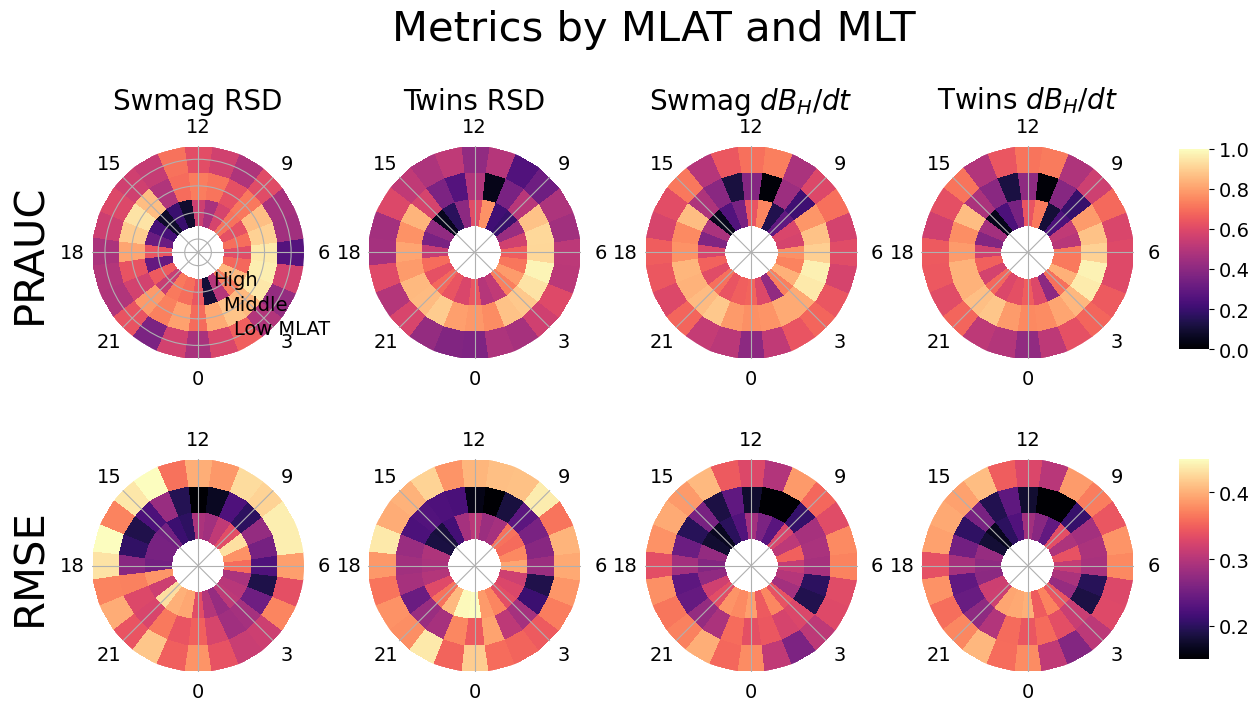

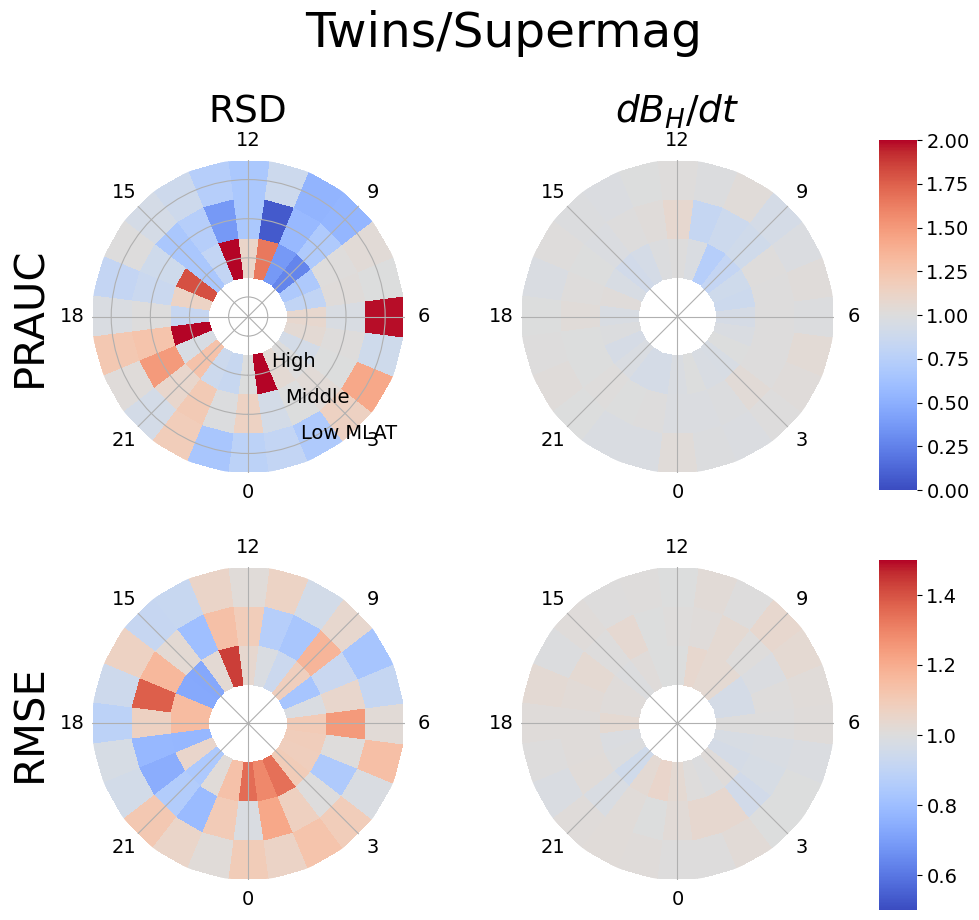

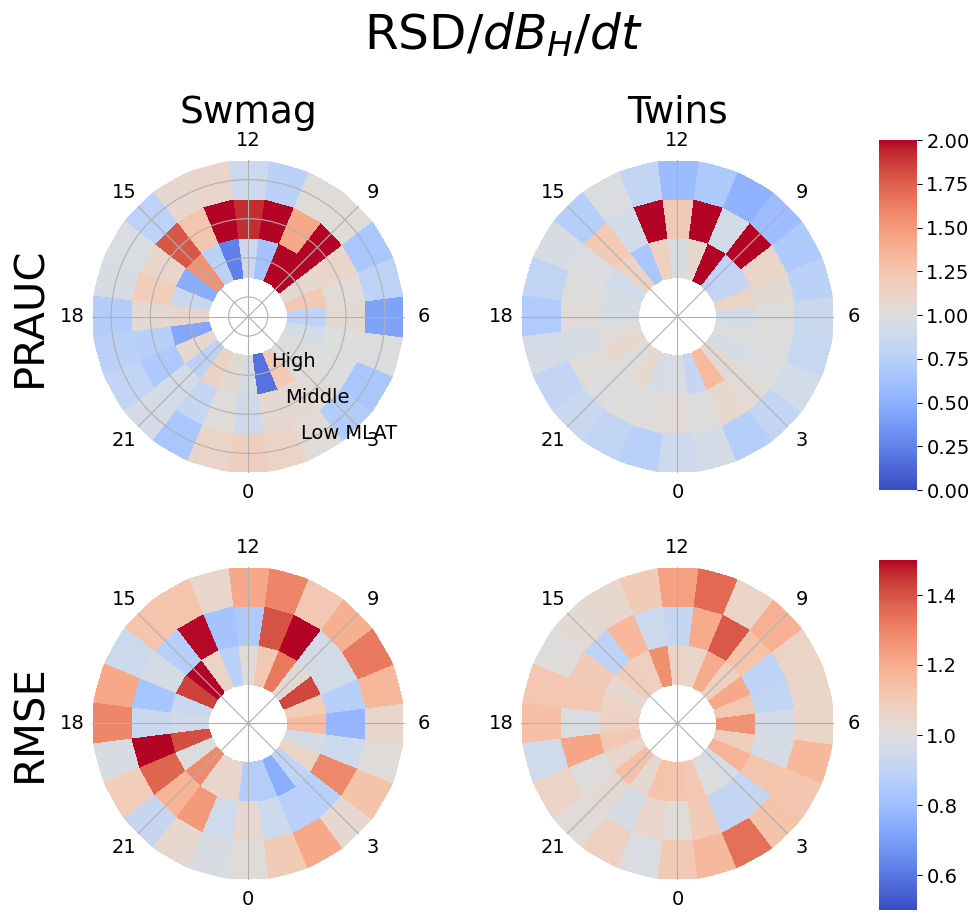

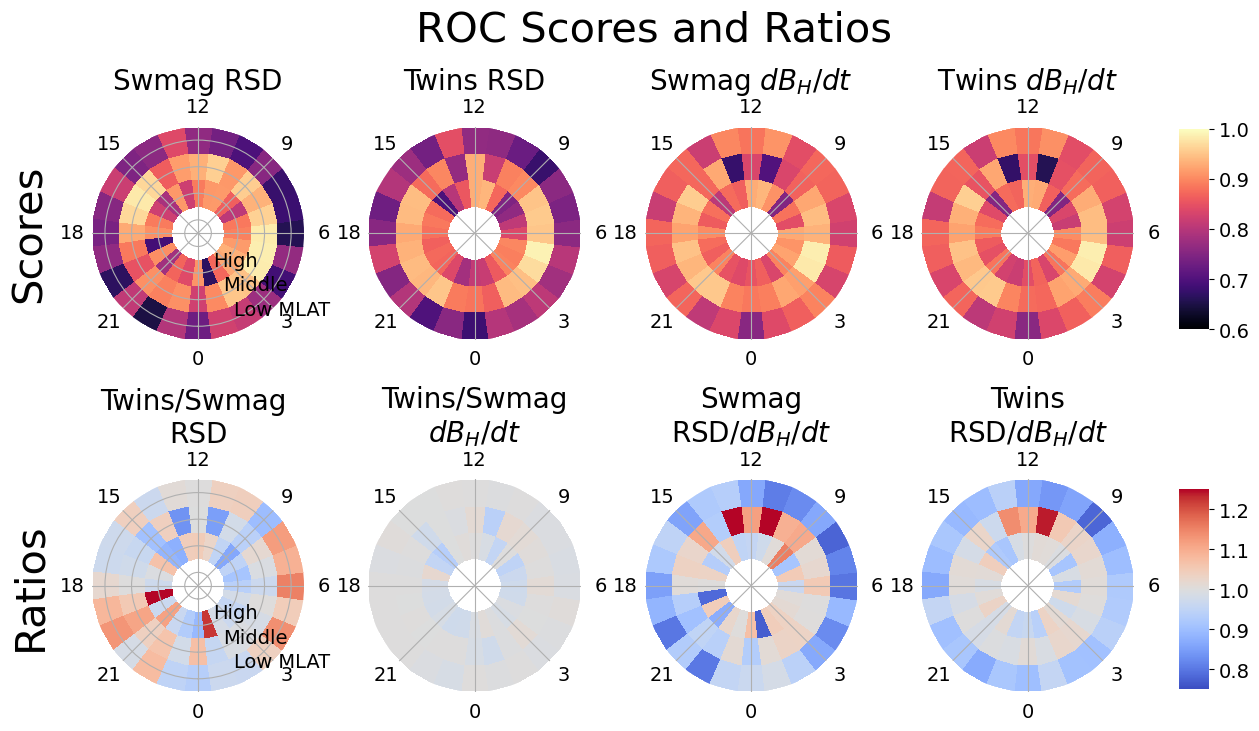

In [47]:
# printing the results for the prauc and rocauc for the dbht and rsd models as a heatmap

pr_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
roc_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
rmse_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
pr_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
roc_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
rmse_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
pr_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
roc_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
rmse_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
pr_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
roc_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
rmse_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])


for i, name in enumerate(names):
	if name == 'blank':
		continue
	for j in range(0,24):
		pr_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['prauc']
		roc_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rocauc']
		rmse_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rmse']
		pr_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['prauc']
		roc_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rocauc']
		rmse_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rmse']
		pr_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['prauc']
		roc_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rocauc']
		rmse_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rmse']
		pr_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['prauc']
		roc_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rocauc']
		rmse_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rmse']

# convertin the values to float
pr_swmag_dbht_df = pr_swmag_dbht_df.astype(float)
roc_swmag_dbht_df = roc_swmag_dbht_df.astype(float)
rmse_swmag_dbht_df = rmse_swmag_dbht_df.astype(float)
pr_swmag_rsd_df = pr_swmag_rsd_df.astype(float)
roc_swmag_rsd_df = roc_swmag_rsd_df.astype(float)
rmse_swmag_rsd_df = rmse_swmag_rsd_df.astype(float)
pr_twins_dbht_df = pr_twins_dbht_df.astype(float)
roc_twins_dbht_df = roc_twins_dbht_df.astype(float)
rmse_twins_dbht_df = rmse_twins_dbht_df.astype(float)
pr_twins_rsd_df = pr_twins_rsd_df.astype(float)
roc_twins_rsd_df = roc_twins_rsd_df.astype(float)
rmse_twins_rsd_df = rmse_twins_rsd_df.astype(float)

pr_score_norm = mpl.colors.Normalize(vmin=00, vmax=1)
roc_score_norm = mpl.colors.Normalize(vmin=0.6, vmax=1)
rmse_score_norm = mpl.colors.Normalize(vmin=0.15, vmax=0.45)
pr_ratio_norm = mpl.colors.Normalize(vmin=0, vmax=2)
roc_ratio_norm = mpl.colors.Normalize(vmin=0.75, vmax=1.25)
rmse_ratio_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2,3]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(2, 4, figsize=(15, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('Metrics by MLAT and MLT', fontsize=30)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,0].pcolormesh(th, r, pr_swmag_rsd_df, cmap='magma', norm=pr_score_norm)
axs[0,0].set_title('Swmag RSD')
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('PRAUC', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,0].pcolormesh(th, r, rmse_swmag_rsd_df, cmap='magma', norm=rmse_score_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
axs[1,0].set_yticks([])
# axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,1].pcolormesh(th, r, pr_twins_rsd_df, cmap='magma', norm=pr_score_norm)
axs[0,1].set_title('Twins RSD')
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks([])
# axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,1].pcolormesh(th, r, rmse_twins_rsd_df, cmap='magma', norm=rmse_score_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks([])
# axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
axs[0,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,2].pcolormesh(th, r, pr_swmag_dbht_df, cmap='magma', norm=pr_score_norm)
axs[0,2].set_title(r'Swmag $dB_H/dt$')
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks([])
# axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,2].pcolormesh(th, r, rmse_swmag_dbht_df, cmap='magma', norm=rmse_score_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks([])
# axs[1,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[0,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_pr = axs[0,3].pcolormesh(th, r, pr_twins_dbht_df, cmap='magma', norm=pr_score_norm)
axs[0,3].set_title(r'Twins $dB_H/dt$')
axs[0,3].invert_yaxis()
axs[0,3].set_xticks(theta_ticks)
axs[0,3].set_xticklabels(theta_labels)
axs[0,3].set_yticks([])
# axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_rmse = axs[1,3].pcolormesh(th, r, rmse_twins_dbht_df, cmap='magma', norm=rmse_score_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,3].invert_yaxis()
axs[1,3].set_xticks(theta_ticks)
axs[1,3].set_xticklabels(theta_labels)
axs[1,3].set_yticks([])
# axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.64, 0.02, 0.2])
fig.colorbar(im_pr, cax=cbar_ax)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.33, 0.02, 0.2])
fig.colorbar(im_rmse, cax=cbar_ax)

plt.subplots_adjust(wspace=0.3, hspace=-0.5, top=1.05)
plt.savefig('plots/metrics_polar_heatmap.png')

# plotting the ratio plots

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('Twins/Supermag', fontsize=35)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,0].pcolormesh(th, r, (pr_twins_rsd_df/pr_swmag_rsd_df), cmap='coolwarm', norm=pr_ratio_norm)
axs[0,0].set_title('RSD', fontsize=27)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('PRAUC', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])


axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,0].pcolormesh(th, r, rmse_twins_rsd_df/rmse_swmag_rsd_df, cmap='coolwarm', norm=rmse_ratio_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
axs[1,0].set_yticks([])
# axs[2,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_pr = axs[0,1].pcolormesh(th, r, pr_twins_dbht_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_ratio_norm)
axs[0,1].set_title(r'$dB_H/dt$', fontsize=27)
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks([])
# axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_rmse = axs[1,1].pcolormesh(th, r, rmse_twins_dbht_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks([])
# axs[2,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.75, 0.50, 0.025, 0.35])
fig.colorbar(im_pr, cax=cbar_ax)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.75, 0.08, 0.025, 0.35])
fig.colorbar(im_rmse, cax=cbar_ax)

plt.subplots_adjust(wspace=-0.3, hspace=0.3, top=0.83)
plt.savefig('plots/model_ratios_polar_heatmap.png')

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw=dict(projection='polar'))
fig.suptitle(r'RSD/$dB_H/dt$', fontsize=35)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,0].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_ratio_norm)
axs[0,0].set_title('Swmag', fontsize=27)
axs[0,0].set_ylabel('PRAUC', labelpad=30, fontsize=30)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,0].pcolormesh(th, r, rmse_swmag_rsd_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm)
axs[1,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_yticks([])
# axs[2,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_pr = axs[0,1].pcolormesh(th, r, pr_twins_rsd_df/pr_twins_dbht_df, cmap='coolwarm', norm=pr_ratio_norm)
axs[0,1].set_title('Twins', fontsize=27)
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks([])
# axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_rmse = axs[1,1].pcolormesh(th, r, rmse_twins_rsd_df/rmse_twins_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks([])
# axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.75, 0.50, 0.025, 0.35])
fig.colorbar(im_pr, cax=cbar_ax)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.75, 0.08, 0.025, 0.35])
fig.colorbar(im_rmse, cax=cbar_ax)

plt.subplots_adjust(wspace=-0.3, hspace=0.3, top=0.83)

plt.savefig('plots/targets_ratios_polar_heatmap.png')


fig, axs = plt.subplots(2,4, figsize=(15,10), subplot_kw=dict(projection='polar'))
fig.suptitle('ROC Scores and Ratios', fontsize=30)

axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,0].pcolormesh(th, r, roc_swmag_rsd_df, cmap='magma', norm=roc_score_norm)
axs[0,0].set_title('Swmag RSD')
axs[0,0].set_ylabel('Scores', labelpad=30, fontsize=30)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,1].pcolormesh(th, r, roc_twins_rsd_df, cmap='magma', norm=roc_score_norm)
axs[0,1].set_title('Twins RSD')
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks([])
# axs[1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[0,2].set_theta_zero_location('S')
axs[0,2].set_title(r'Swmag $dB_H/dt$')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,2].pcolormesh(th, r, roc_swmag_dbht_df, cmap='magma', norm=roc_score_norm)
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks([])
# axs[2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[0,3].set_theta_zero_location('S')
axs[0,3].set_title(r'Twins $dB_H/dt$')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_score = axs[0,3].pcolormesh(th, r, roc_twins_dbht_df, cmap='magma', norm=roc_score_norm)
axs[0,3].invert_yaxis()
axs[0,3].set_xticks(theta_ticks)
axs[0,3].set_xticklabels(theta_labels)
axs[0,3].set_yticks([])
# axs[3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,0].pcolormesh(th, r, roc_twins_rsd_df/roc_swmag_rsd_df, cmap='coolwarm', norm=roc_ratio_norm)
# axs[1,0].set_title('SWMAG RSD')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_ylabel('Ratios', labelpad=30, fontsize=30)
axs[1,0].set_title('Twins/Swmag \nRSD')
axs[1,0].set_yticks(rad)
axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,1].pcolormesh(th, r, roc_twins_dbht_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_ratio_norm)
axs[1,1].set_title('Twins/Swmag\n'+r'$dB_H/dt$')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks([])
# axs[1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,2].pcolormesh(th, r, roc_swmag_rsd_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_ratio_norm)
axs[1,2].set_title('Swmag\n'+r'RSD/$dB_H/dt$')
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks([])
# axs[2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
im_ratio = axs[1,3].pcolormesh(th, r, roc_twins_rsd_df/roc_twins_dbht_df, cmap='coolwarm', norm=roc_ratio_norm)
axs[1,3].set_title('Twins\n'+r'RSD/$dB_H/dt$')
axs[1,3].invert_yaxis()
axs[1,3].set_xticks(theta_ticks)
axs[1,3].set_xticklabels(theta_labels)
axs[1,3].set_yticks([])
# axs[3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.66, 0.02, 0.2])
fig.colorbar(im_score, cax=cbar_ax)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.2])
fig.colorbar(im_ratio, cax=cbar_ax)

plt.subplots_adjust(wspace=0.3, hspace=-0.4, top=1.05)

plt.savefig('plots/roc_polar.png')


                     predicted_mean  predicted_std  actual  dbht_mean  \
dates                                                                   
2010-02-15 00:50:00        0.000122       0.000320     0.0   2.173759   
2010-02-15 00:51:00        0.000134       0.000347     0.0   1.333276   
2010-02-15 00:52:00        0.000131       0.000343     0.0   0.908189   
2010-02-15 00:53:00        0.000135       0.000353     0.0   1.280879   
2010-02-15 00:54:00        0.000133       0.000351     0.0   0.820815   
...                             ...            ...     ...        ...   
2016-01-02 13:15:00        0.008531       0.029289     1.0  10.207664   
2016-01-02 13:16:00        0.010418       0.033480     1.0   4.722299   
2016-01-02 13:17:00        0.006413       0.022408     1.0   4.666261   
2016-01-02 13:18:00        0.004531       0.017178     1.0   7.690697   
2016-01-02 13:19:00        0.005016       0.018843     1.0   7.327088   

                     dbht_std   dbht_max  dbht_med

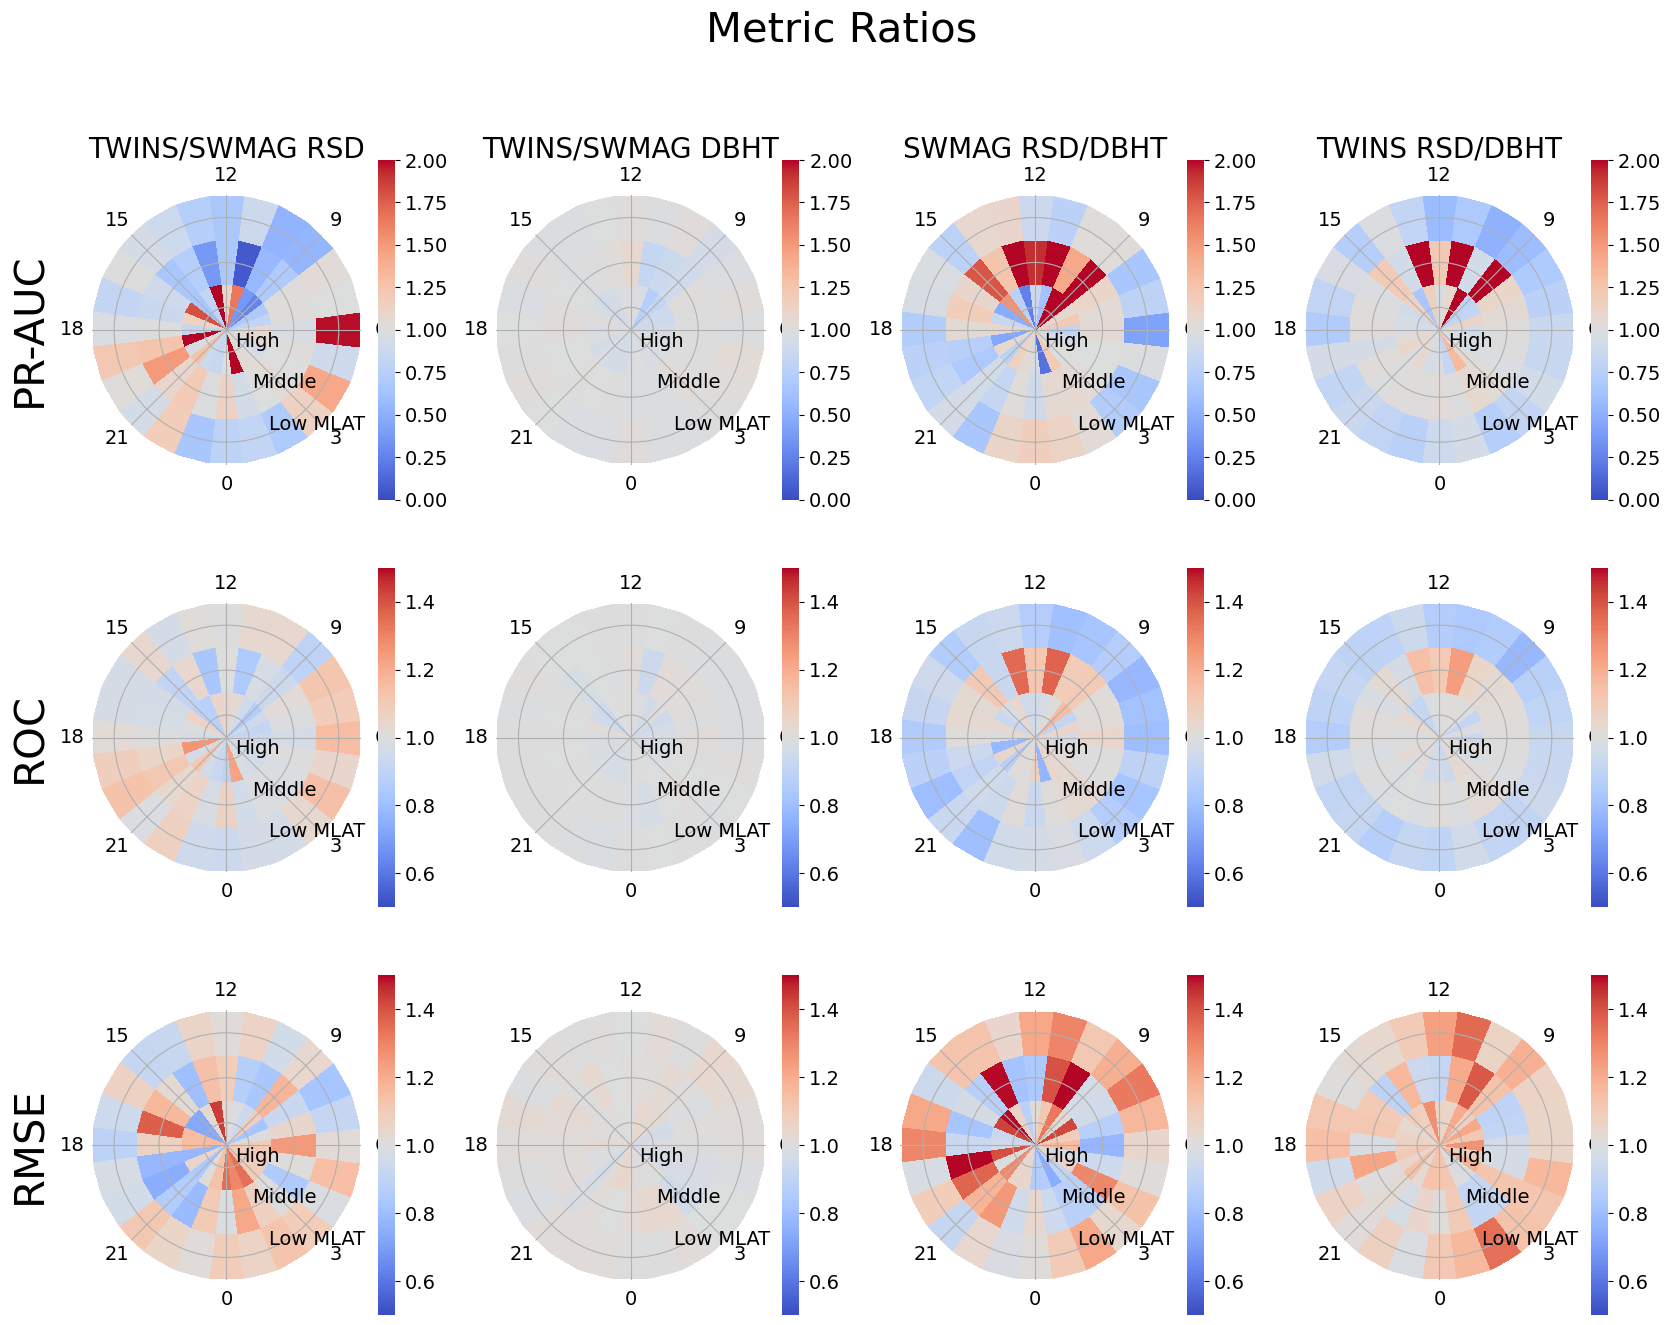

In [48]:
# printing the results for the prauc and rocauc for the dbht and rsd models as a heatmap

pr_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
print(swmag_dbht_df)
print(swmag_dbht_df['MLAT'].min(), swmag_dbht_df['MLAT'].max())

for i, name in enumerate(names):
	for j in range(0,24):
		pr_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['prauc']
		roc_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rocauc']
		rmse_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rmse']
		pr_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['prauc']
		roc_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rocauc']
		rmse_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rmse']
		pr_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['prauc']
		roc_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rocauc']
		rmse_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rmse']
		pr_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['prauc']
		roc_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rocauc']
		rmse_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rmse']

# convertin the values to float
pr_swmag_dbht_df = pr_swmag_dbht_df.astype(float)
roc_swmag_dbht_df = roc_swmag_dbht_df.astype(float)
rmse_swmag_dbht_df = rmse_swmag_dbht_df.astype(float)
pr_swmag_rsd_df = pr_swmag_rsd_df.astype(float)
roc_swmag_rsd_df = roc_swmag_rsd_df.astype(float)
rmse_swmag_rsd_df = rmse_swmag_rsd_df.astype(float)
pr_twins_dbht_df = pr_twins_dbht_df.astype(float)
roc_twins_dbht_df = roc_twins_dbht_df.astype(float)
rmse_twins_dbht_df = rmse_twins_dbht_df.astype(float)
pr_twins_rsd_df = pr_twins_rsd_df.astype(float)
roc_twins_rsd_df = roc_twins_rsd_df.astype(float)
rmse_twins_rsd_df = rmse_twins_rsd_df.astype(float)

pr_norm = mpl.colors.Normalize(vmin=0, vmax=2)
roc_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)
rmse_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)
# plotting_norm = None

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(3, 4, figsize=(20, 15), subplot_kw=dict(projection='polar'))
fig.suptitle('Metric Ratios', fontsize=30)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, (pr_twins_rsd_df/pr_swmag_rsd_df), cmap='coolwarm', norm=pr_norm), ax=axs[0,0])
axs[0,0].set_title('TWINS/SWMAG RSD')
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('PR-AUC', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, roc_twins_rsd_df/roc_swmag_rsd_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,0])
# axs[1,0].set_title('SWMAG RSD')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_ylabel('ROC', labelpad=30, fontsize=30)
axs[1,0].set_yticks(rad)
axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,0].pcolormesh(th, r, rmse_twins_rsd_df/rmse_swmag_rsd_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,0])
# axs[1,0].set_title('SWMAG RSD')
axs[2,0].invert_yaxis()
axs[2,0].set_xticks(theta_ticks)
axs[2,0].set_xticklabels(theta_labels)
axs[2,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
axs[2,0].set_yticks(rad)
axs[2,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, pr_twins_dbht_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_norm), ax=axs[0,1])
axs[0,1].set_title('TWINS/SWMAG DBHT')
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks(rad)
axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, roc_twins_dbht_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,1])
# axs[1,0].set_title('SWMAG RSD')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks(rad)
axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,1].pcolormesh(th, r, rmse_twins_dbht_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,1])
# axs[1,0].set_title('SWMAG RSD')
axs[2,1].invert_yaxis()
axs[2,1].set_xticks(theta_ticks)
axs[2,1].set_xticklabels(theta_labels)
axs[2,1].set_yticks(rad)
axs[2,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
axs[0,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,2].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_norm), ax=axs[0,2])
axs[0,2].set_title('SWMAG RSD/DBHT')
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks(rad)
axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,2].pcolormesh(th, r, roc_swmag_rsd_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,2])
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks(rad)
axs[1,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,2].pcolormesh(th, r, rmse_swmag_rsd_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,2])
# axs[1,0].set_title('SWMAG RSD')
axs[2,2].invert_yaxis()
axs[2,2].set_xticks(theta_ticks)
axs[2,2].set_xticklabels(theta_labels)
axs[2,2].set_yticks(rad)
axs[2,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])



# Plotting the PR-AUC scores on a polar plot
axs[0,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,3].pcolormesh(th, r, pr_twins_rsd_df/pr_twins_dbht_df, cmap='coolwarm', norm=pr_norm), ax=axs[0,3])
axs[0,3].set_title('TWINS RSD/DBHT')
axs[0,3].invert_yaxis()
axs[0,3].set_xticks(theta_ticks)
axs[0,3].set_xticklabels(theta_labels)
axs[0,3].set_yticks(rad)
axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,3].pcolormesh(th, r, roc_twins_rsd_df/roc_twins_dbht_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,3])
axs[1,3].invert_yaxis()
axs[1,3].set_xticks(theta_ticks)
axs[1,3].set_xticklabels(theta_labels)
axs[1,3].set_yticks(rad)
axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,3].pcolormesh(th, r, rmse_twins_rsd_df/rmse_twins_dbht_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,3])
# axs[1,0].set_title('SWMAG RSD')
axs[2,3].invert_yaxis()
axs[2,3].set_xticks(theta_ticks)
axs[2,3].set_xticklabels(theta_labels)
axs[2,3].set_yticks(rad)
axs[2,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])


plt.savefig('plots/metric_ratios_polar_heatmap.png')


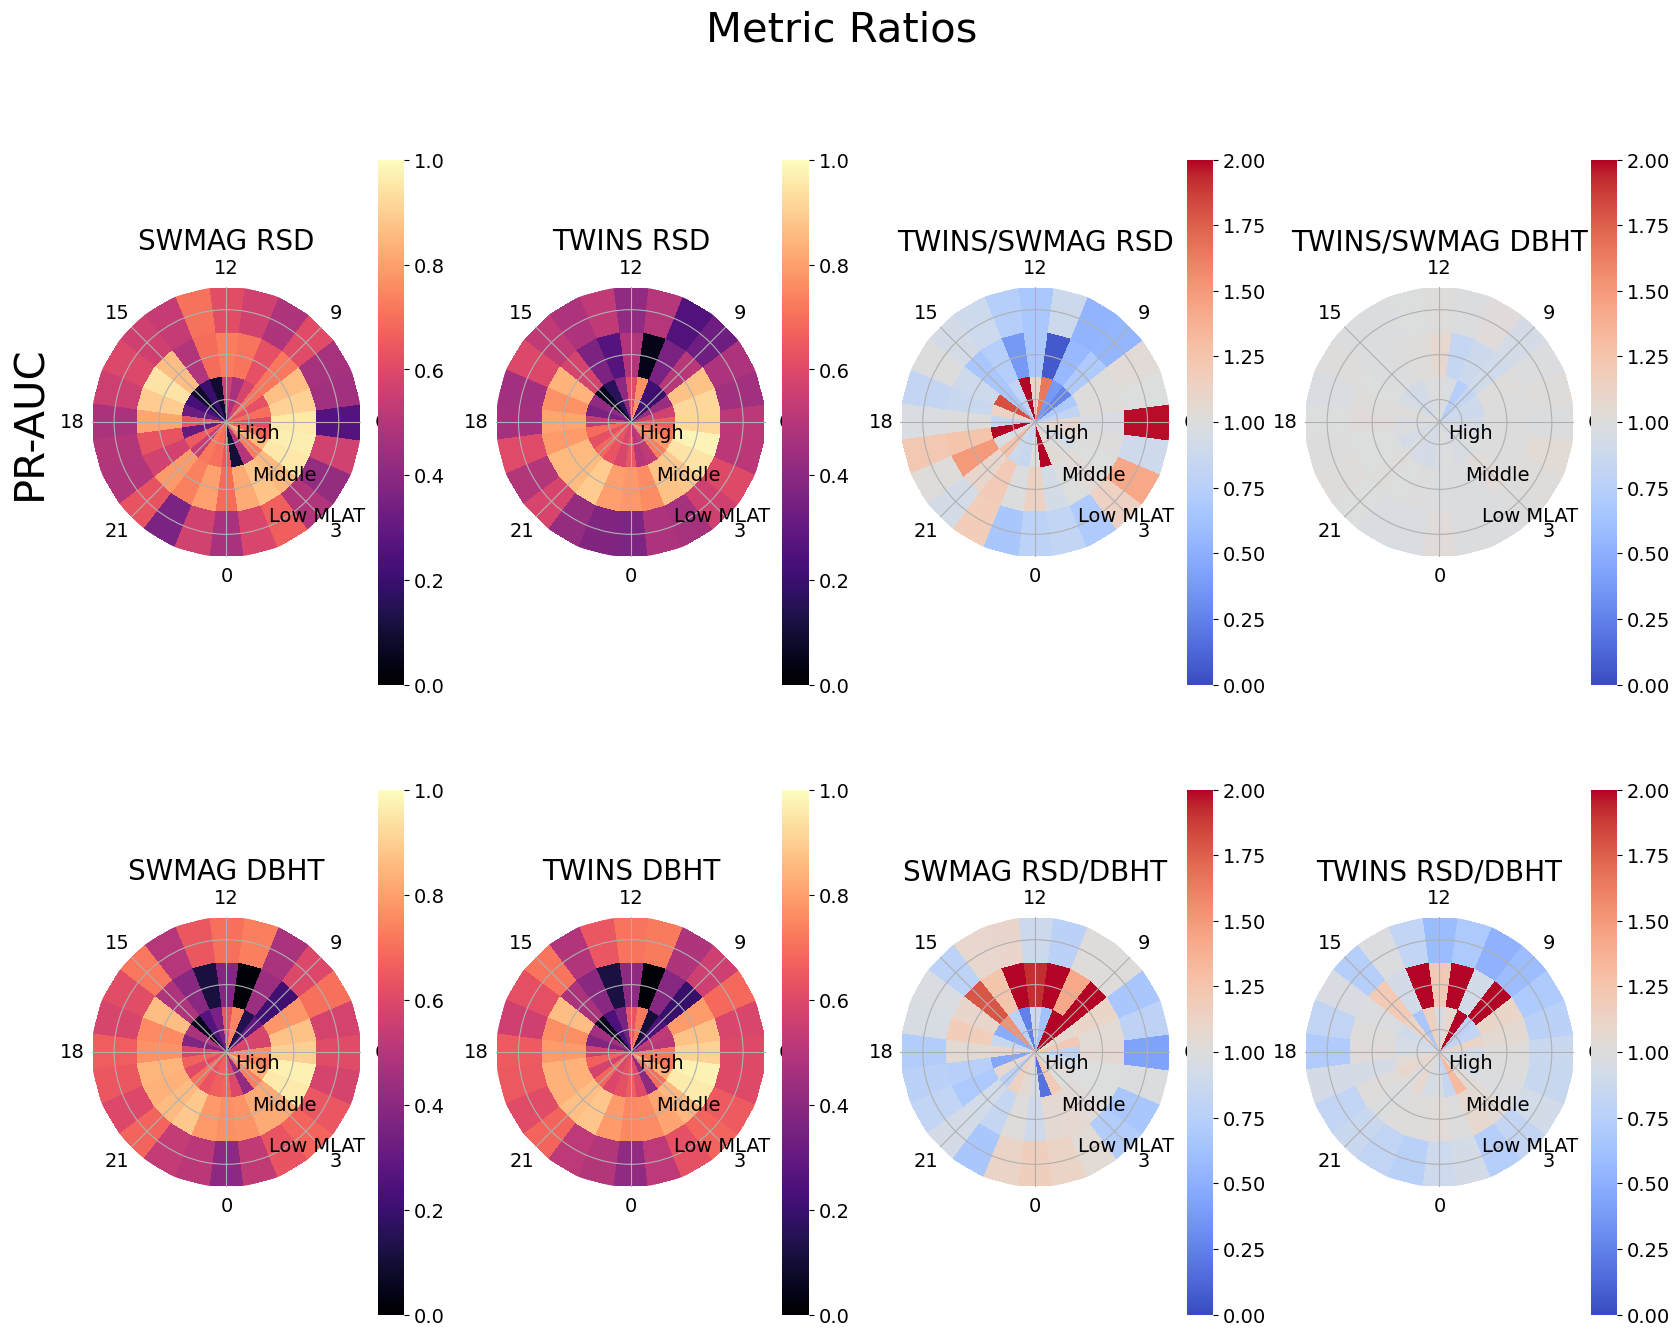

In [49]:
names = ['low', 'mid', 'high']

pr_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])


for i, name in enumerate(names):
	for j in range(0,24):
		pr_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['prauc']
		roc_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rocauc']
		rmse_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rmse']
		pr_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['prauc']
		roc_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rocauc']
		rmse_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rmse']
		pr_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['prauc']
		roc_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rocauc']
		rmse_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rmse']
		pr_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['prauc']
		roc_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rocauc']
		rmse_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rmse']

# convertin the values to float
pr_swmag_dbht_df = pr_swmag_dbht_df.astype(float)
roc_swmag_dbht_df = roc_swmag_dbht_df.astype(float)
rmse_swmag_dbht_df = rmse_swmag_dbht_df.astype(float)
pr_swmag_rsd_df = pr_swmag_rsd_df.astype(float)
roc_swmag_rsd_df = roc_swmag_rsd_df.astype(float)
rmse_swmag_rsd_df = rmse_swmag_rsd_df.astype(float)
pr_twins_dbht_df = pr_twins_dbht_df.astype(float)
roc_twins_dbht_df = roc_twins_dbht_df.astype(float)
rmse_twins_dbht_df = rmse_twins_dbht_df.astype(float)
pr_twins_rsd_df = pr_twins_rsd_df.astype(float)
roc_twins_rsd_df = roc_twins_rsd_df.astype(float)
rmse_twins_rsd_df = rmse_twins_rsd_df.astype(float)

ratio_norm = mpl.colors.Normalize(vmin=0, vmax=2)
metric_norm = mpl.colors.Normalize(vmin=0, vmax=1)
# plotting_norm = None

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(2, 4, figsize=(20, 15), subplot_kw=dict(projection='polar'))
fig.suptitle('Metric Ratios', fontsize=30)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, pr_swmag_rsd_df, cmap='magma', norm=metric_norm), ax=axs[0,0])
axs[0,0].set_title('SWMAG RSD')
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('PR-AUC', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, pr_twins_rsd_df, cmap='magma', norm=metric_norm), ax=axs[0,1])
axs[0,1].set_title('TWINS RSD')
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks(rad)
axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, pr_swmag_dbht_df, cmap='magma', norm=metric_norm), ax=axs[1,0])
axs[1,0].set_title('SWMAG DBHT')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_yticks(rad)
axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, pr_twins_dbht_df, cmap='magma', norm=metric_norm), ax=axs[1,1])
axs[1,1].set_title('TWINS DBHT')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks(rad)
axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[0,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,2].pcolormesh(th, r, (pr_twins_rsd_df/pr_swmag_rsd_df), cmap='coolwarm', norm=ratio_norm), ax=axs[0,2])
axs[0,2].set_title('TWINS/SWMAG RSD')
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks(rad)
axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[0,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,3].pcolormesh(th, r, pr_twins_dbht_df/pr_swmag_dbht_df, cmap='coolwarm', norm=ratio_norm), ax=axs[0,3])
axs[0,3].set_title('TWINS/SWMAG DBHT')
axs[0,3].invert_yaxis()
axs[0,3].set_xticks(theta_ticks)
axs[0,3].set_xticklabels(theta_labels)
axs[0,3].set_yticks(rad)
axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,2].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=ratio_norm), ax=axs[1,2])
axs[1,2].set_title('SWMAG RSD/DBHT')
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks(rad)
axs[1,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[1,3].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,3].pcolormesh(th, r, pr_twins_rsd_df/pr_twins_dbht_df, cmap='coolwarm', norm=ratio_norm), ax=axs[1,3])
axs[1,3].set_title('TWINS RSD/DBHT')
axs[1,3].invert_yaxis()
axs[1,3].set_xticks(theta_ticks)
axs[1,3].set_xticklabels(theta_labels)
axs[1,3].set_yticks(rad)
axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

plt.show()

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ipykernel_3483441/2850360253.py:7: RuntimeWarning: invalid value encountered in scalar divide
  aucmin = (1+((1-ds_skew)*np.log(1-ds_skew)/ds_skew))
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ipykernel_3483441/2850360253.py:7: RuntimeWarning: invalid value encountered in scalar divide
  aucmin = (1+((1-ds_skew)*np.log(1-ds_skew)/ds_skew))
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ipykernel_3483441/2850360253.py:7: RuntimeWarning: invalid value e

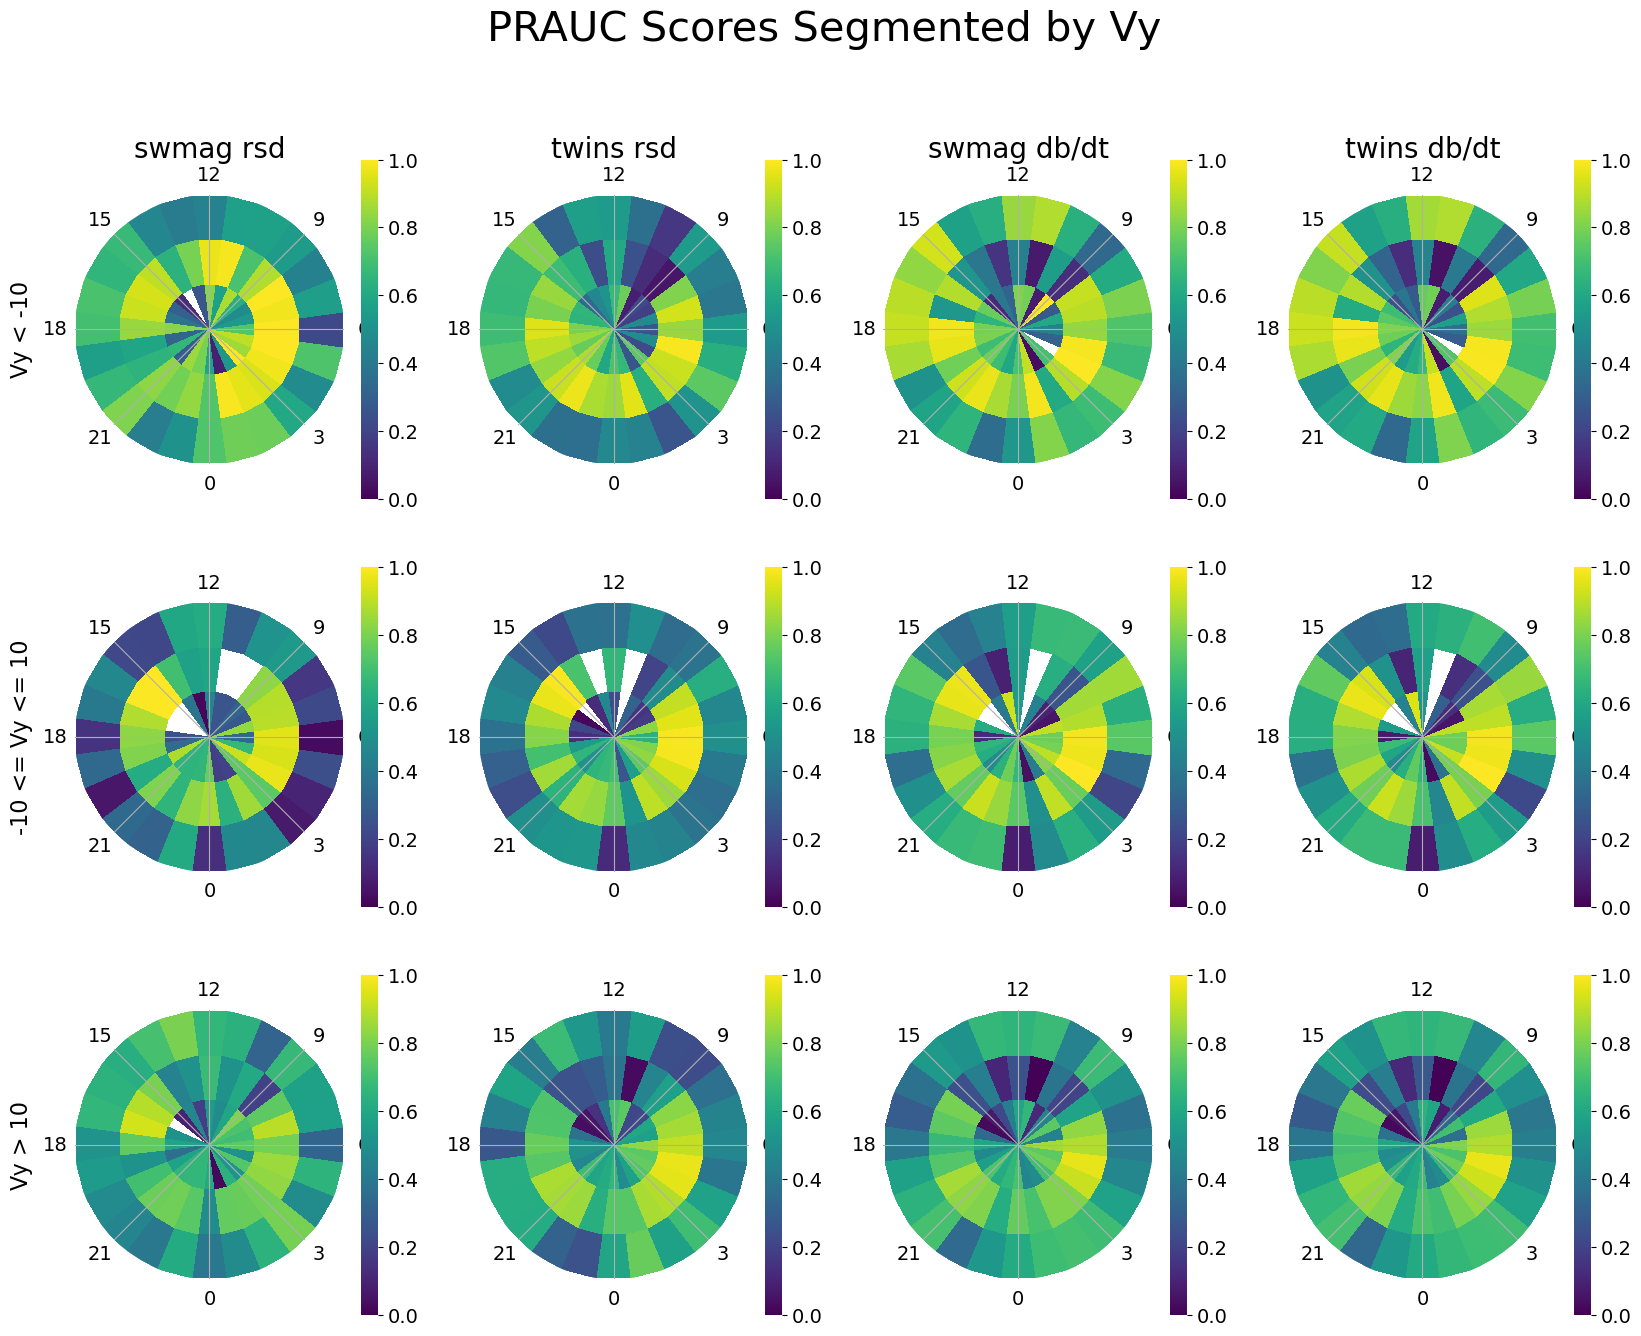

In [50]:
lower_lat_bound = 55
upper_lat_bound = 67
sep_var = 'Vy'
sep_var_bins = [-10, 10]
metric = 'prauc'

def get_sep_var_and_lat_bins(df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound):
	
	if sep_var_bins == None:
		sep_var_bins = [df[sep_var].quantile(0.25), df[sep_var].quantile(0.75)]
	if 'MLAT' not in df.columns:
		raise ValueError('MLAT column not found in the dataframe')
	if sep_var not in df.columns:
		raise ValueError(f'{sep_var} column not found in the dataframe')
	
	var_sep_low_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]


	final_dict = {'low_mlat_low_sep': var_sep_low_mlat_low, 'low_mlat_mid_sep': var_sep_mid_mlat_low, 'low_mlat_high_sep': var_sep_high_mlat_low,
				  'mid_mlat_low_sep': var_sep_low_mlat_mid, 'mid_mlat_mid_sep': var_sep_mid_mlat_mid, 'mid_mlat_high_sep': var_sep_high_mlat_mid,
				  'high_mlat_low_sep': var_sep_low_mlat_high, 'high_mlat_mid_sep': var_sep_mid_mlat_high, 'high_mlat_high_sep': var_sep_high_mlat_high}
	
	return final_dict


def calculating_individual_mlt_metrics(dict, metric='prauc'):

	results_dict = {'low_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'mid_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'high_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])}

	lats = ['low', 'mid', 'high']
	var_seps = ['low', 'mid', 'high']

	# calculating the metrics for the low, mid and high latitudes
	for lat in lats:
		for sep in var_seps:
			for i in range(0, 24):
				temp_df = dict[f'{lat}_mlat_{sep}_sep'][dict[f'{lat}_mlat_{sep}_sep']['MLT'] == i]
				try:
					if metric == 'prauc':
						# second_output, first_output, __ = precision_recall_curve(temp_df['actual'], temp_df['predicted_mean'])
						# results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = calibrating_prauc(y_true=temp_df['actual'], y_pred=temp_df['predicted_mean'])
					elif metric == 'rocauc':
						first_output, second_output, __ = roc_curve(temp_df['actual'], temp_df['predicted_mean'])
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
					elif metric == 'ratio':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['actual'].sum()/len(temp_df)

					else:
						raise ValueError('Metric not recognized')

				except ValueError:
					print(f'No data found for {lat} lat and {sep} sep at {i} MLT')
					print(dict[f'{lat}_mlat_{sep}_sep'])
					raise
					results_dict[f'{sep}_sep_var_df'].loc[i,lat] = np.nan
					
			results_dict[f'{sep}_sep_var_df'] = results_dict[f'{sep}_sep_var_df'].astype(float)

	return results_dict

swmag_dbht_sep_dict = get_sep_var_and_lat_bins(swmag_dbht_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
twins_dbht_sep_dict = get_sep_var_and_lat_bins(twins_dbht_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
swmag_rsd_sep_dict = get_sep_var_and_lat_bins(swmag_rsd_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
twins_rsd_sep_dict = get_sep_var_and_lat_bins(twins_rsd_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)

if sep_var_bins == None:
	sep_var_bins = ['25%', '75%']

swmag_dbht_results = calculating_individual_mlt_metrics(swmag_dbht_sep_dict, metric=metric)
twins_dbht_results = calculating_individual_mlt_metrics(twins_dbht_sep_dict, metric=metric)
swmag_rsd_results = calculating_individual_mlt_metrics(swmag_rsd_sep_dict, metric=metric)
twins_rsd_results = calculating_individual_mlt_metrics(twins_rsd_sep_dict, metric=metric)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axes = plt.subplots(3,4, figsize=(20, 15), subplot_kw=dict(projection='polar'))

if metric != 'ratio':
	plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
else:
	# plotting_norm = mpl.colors.LogNorm()
	plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)

# plotting the results segmented by parameter values
plt.suptitle(f'{metric.upper()} Scores Segmented by {sep_var}', fontsize=30)
for i, (results, title) in enumerate(zip([swmag_rsd_results, twins_rsd_results, swmag_dbht_results, twins_dbht_results], ['swmag rsd', 'twins rsd', 'swmag db/dt', 'twins db/dt'])):
	axes[0,i].set_title(title)
	for j, (key, value) in enumerate(results.items()):
		if i == 0:
			if j == 0:
				axes[j,i].set_ylabel(f'{sep_var} < {sep_var_bins[0]}', labelpad=30)
			elif j == 1:
				axes[j,i].set_ylabel(f'{sep_var_bins[0]} <= {sep_var} <= {sep_var_bins[1]}', labelpad=30)
			else:
				axes[j,i].set_ylabel(f'{sep_var} > {sep_var_bins[1]}', labelpad=30)
		axes[j,i].set_theta_zero_location('S')
		r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
		cbar = fig.colorbar(axes[j,i].pcolormesh(th, r, value, cmap='viridis', norm=plotting_norm), ax=axes[j,i])
		
		axes[j,i].invert_yaxis()
		axes[j,i].set_xticks(theta_ticks)
		axes[j,i].set_xticklabels(theta_labels)
		axes[j,i].set_yticks([])
plt.savefig(f'plots/{metric}_scores_segmented_by_{sep_var}.png')


Region: GRL-0
SWMAG: 	F1: 0.6166	AUC: 0.6762
TWIN: 	F1: 0.6218	AUC: 0.6796
ALT: 	F1: 0.522	AUC: 0.4726


KeyError: 'GRL-0'

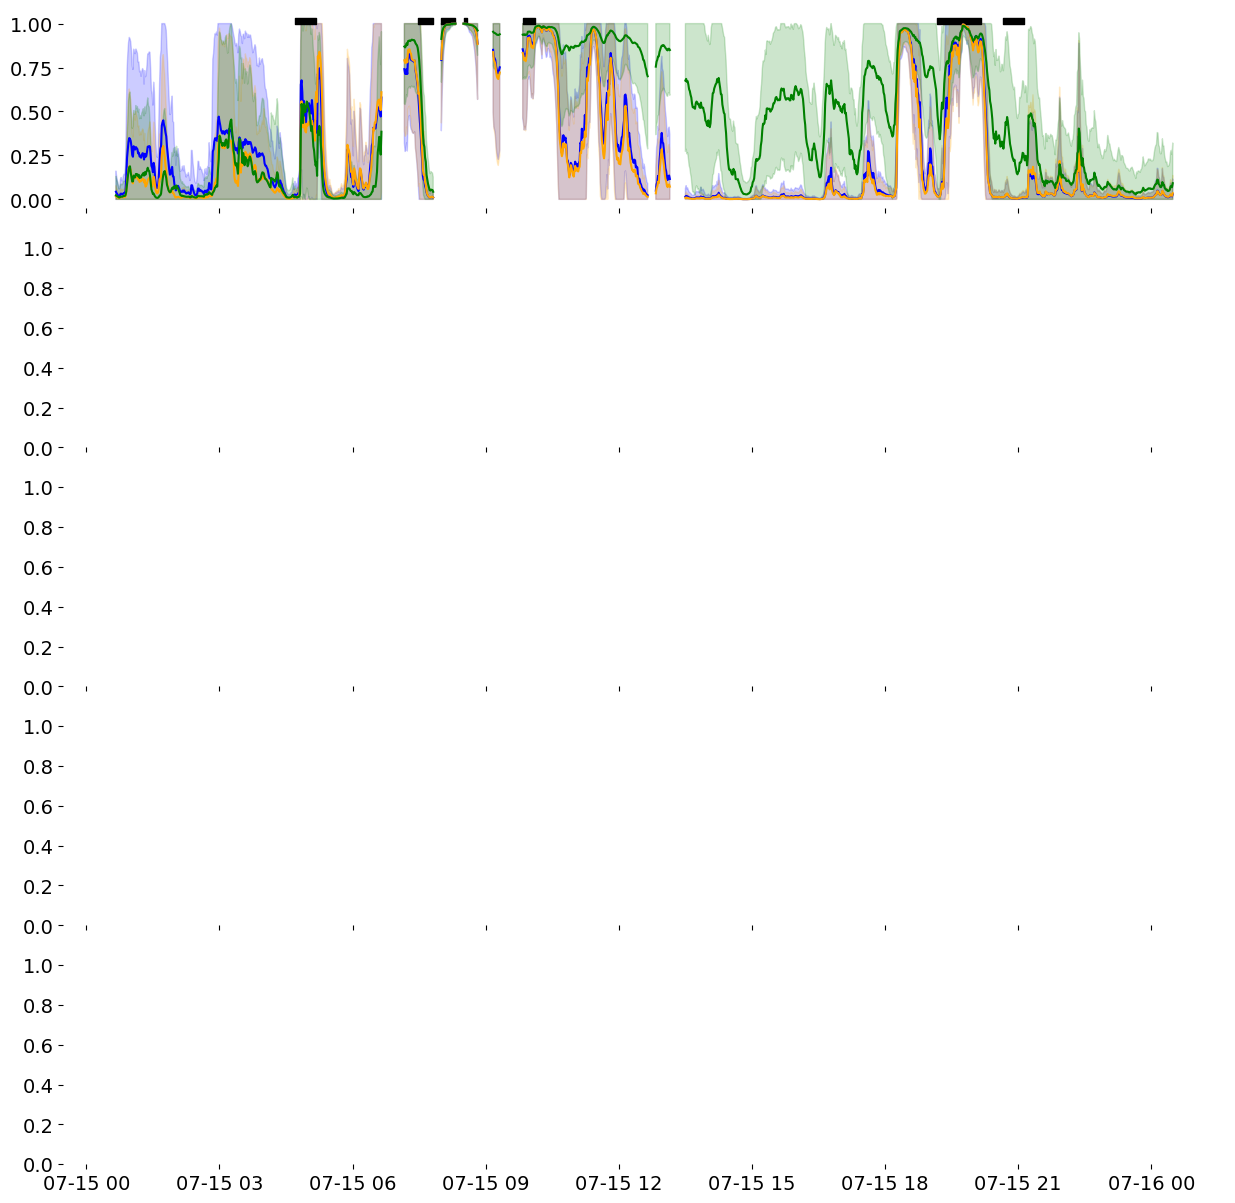

In [ ]:
selected_region = 'FSC-6'

def preparing_results_plotting(region, start_date, end_date):

	list_oversampled = ['CEU-2', 'GRL-0', 'JPN-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-1']
	if region in list_oversampled:
		swmag_results = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-oversampling.feather')
		twins_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
		alt_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_alt_method_v2_maxpooling_oversampling.feather')
	else:
		swmag_results = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-1.feather')
		twins_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
		alt_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_alt_method_v2_maxpooling.feather')

	swmag_results.set_index('dates', inplace=True)
	twins_results.set_index('dates', inplace=True)
	alt_results.set_index('dates', inplace=True)

	print(f'Region: {sel_reg}')
	prec, rec, __ = precision_recall_curve(y_true=swmag_results['actual'], probas_pred=swmag_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(swmag_results['actual'], swmag_results['predicted_mean'])
	print(f'SWMAG: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	prec, rec, __ = precision_recall_curve(y_true=twins_results['actual'], probas_pred=twins_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(twins_results['actual'], twins_results['predicted_mean'])
	print(f'TWIN: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	prec, rec, __ = precision_recall_curve(y_true=alt_results['actual'], probas_pred=alt_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(alt_results['actual'], alt_results['predicted_mean'])
	print(f'ALT: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	# start_date = '2012-03-06 00:00:00'
	# end_date = '2012-03-10 12:00:00'

	plotting_range = pd.date_range(start_date, end_date, freq='min')
	plotting_df = pd.DataFrame(index=plotting_range)
	plotting_df = plotting_df.join(swmag_results['actual'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_mean'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_std'], how='left')
	plotting_df = plotting_df.join(twins_results['predicted_mean'], how='left', rsuffix='_twins')
	plotting_df = plotting_df.join(twins_results['predicted_std'], how='left', rsuffix='_twins')
	plotting_df = plotting_df.join(alt_results['predicted_mean'], how='left', rsuffix='_alt')
	plotting_df = plotting_df.join(alt_results['predicted_std'], how='left', rsuffix='_alt')
	plotting_df['swmag_fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
	plotting_df['swmag_fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
	plotting_df['twins_fill_bottom'] = plotting_df['predicted_mean_twins'] - plotting_df['predicted_std_twins']
	plotting_df['twins_fill_top'] = plotting_df['predicted_mean_twins'] + plotting_df['predicted_std_twins']
	plotting_df['alt_fill_bottom'] = plotting_df['predicted_mean_alt'] - plotting_df['predicted_std_alt']
	plotting_df['alt_fill_top'] = plotting_df['predicted_mean_alt'] + plotting_df['predicted_std_alt']
	plotting_df.clip(lower=0, upper=1, inplace=True)
	plotting_df['bottom'] = plotting_df['actual']*1.00
	plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

start_date = '2012-07-10 00:00:00'
end_date = '2012-07-16 12:00:00'
# selected_regions = ['GRL-2', 'FSC-6', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-1']
selected_regions = ['GRL-0', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-0']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_results_plotting(sel_reg, start_date, end_date)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean'], color='blue', label='SWMAG')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'swmag_fill_bottom'], plotting_df.loc[start_date:end_date, 'swmag_fill_top'], color='blue', alpha=0.2)
	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_twins'], color='orange', label='TWINS')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'twins_fill_bottom'], plotting_df.loc[start_date:end_date, 'twins_fill_top'], color='orange', alpha=0.2)
	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_alt'], color='green', label='ALT')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'alt_fill_bottom'], plotting_df.loc[start_date:end_date, 'alt_fill_top'], color='green', alpha=0.2)
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	mlat = str(round(results[sel_reg]['mean_lat'], 2))
	axes[i].set_title(f'Region: {sel_reg} - MLAT: {mlat}', fontsize=20)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.02,1.04)

axes[1].legend(loc='lower left')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=35)
axes[(len(selected_regions)-1)//2].yaxis.set_label_coords(-0.04,-0.1)
axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=20)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'plots/GEM_2024_plots/regions_example.png')


(15962, 3)
                     predicted_mean  predicted_std  actual
dates                                                     
2016-01-02 13:15:00        0.000015       0.000039     0.0
2016-01-02 13:16:00        0.000014       0.000037     0.0
2016-01-02 13:17:00        0.000015       0.000039     0.0
2016-01-02 13:18:00        0.000020       0.000054     0.0
2016-01-02 13:19:00        0.000018       0.000051     0.0
(15962, 3)
                     predicted_mean  predicted_std  actual
dates                                                     
2016-01-02 13:15:00        0.000001       0.000005     0.0
2016-01-02 13:16:00        0.000001       0.000005     0.0
2016-01-02 13:17:00        0.000001       0.000006     0.0
2016-01-02 13:18:00        0.000002       0.000009     0.0
2016-01-02 13:19:00        0.000002       0.000009     0.0
(15375, 3)
                     predicted_mean  predicted_std  actual
dates                                                     
2015-11-07 00:25:00    

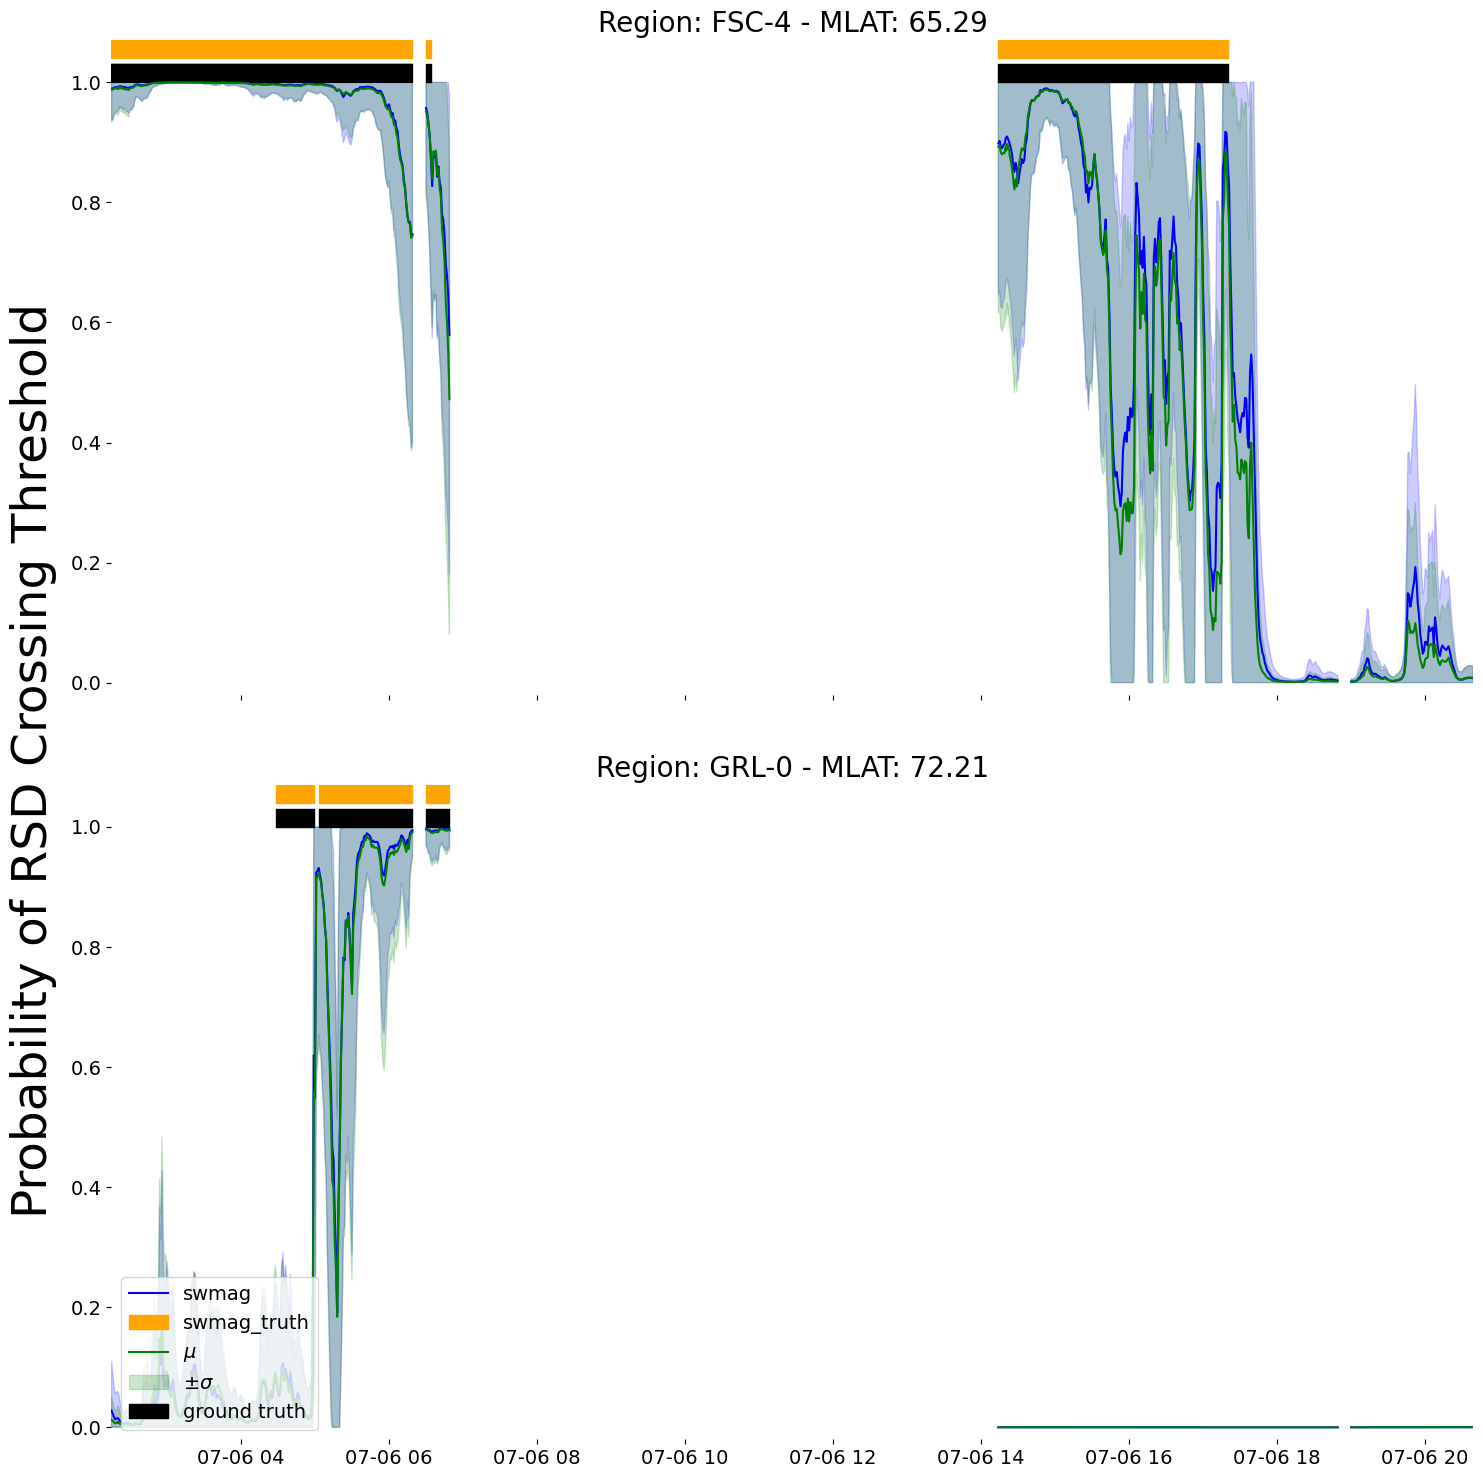

In [65]:
selected_region = 'FSC-6'

def preparing_dbht_results_plotting(region, model_type, target, start_date, end_date):

	results_dict = {}
	list_oversampled = ['GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-1', 'JPN-0']

	if key in list_of_oversampled_regions:
		results_dict['swmag_rsd'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{region}_version_swmag_alt_v4_oversampling.feather')
		results_dict['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_dbht_oversampling.feather')
		results_dict['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_oversampling.feather')
		results_dict['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_dbht_oversampling.feather')
	
	elif region == 'ALSK' or region == 'HUD-1':
		results_dict['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_dbht_oversampling.feather')
		results_dict['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_oversampling.feather')
		results_dict['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_alt_v4.feather')
		results_dict['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_dbht.feather')

	else:
		results_dict['swmag_rsd'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{region}_version_swmag_alt_v4.feather')
		results_dict['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_dbht.feather')
		results_dict['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_alt_v4.feather')
		results_dict['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_dbht.feather')


	if model_type == 'both':
		results_twins = results_dict[f'twins_{target}']
		results_twins.set_index('dates', inplace=True)
		results_swmag = results_dict[f'swmag_{target}']
		results_swmag.set_index('dates', inplace=True)

		print(results_twins.shape)
		print(results_twins.tail())
		print(results_swmag.shape)
		print(results_swmag.tail())

		plotting_range = pd.date_range(start_date, end_date, freq='min')
		plotting_df = pd.DataFrame(index=plotting_range)

		plotting_df = plotting_df.join(results_twins['actual'], how='left')
		plotting_df = plotting_df.join(results_twins['predicted_mean'], how='left')
		plotting_df = plotting_df.join(results_twins['predicted_std'], how='left')

		plotting_df = plotting_df.join(results_swmag['actual'], how='left', rsuffix='_swmag')
		plotting_df = plotting_df.join(results_swmag['predicted_mean'], how='left', rsuffix='_swmag')
		plotting_df = plotting_df.join(results_swmag['predicted_std'], how='left', rsuffix='_swmag')

		plotting_df['fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
		plotting_df['fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
		plotting_df['fill_bottom_swmag'] = plotting_df['predicted_mean_swmag'] - plotting_df['predicted_std_swmag']
		plotting_df['fill_top_swmag'] = plotting_df['predicted_mean_swmag'] + plotting_df['predicted_std_swmag']
		plotting_df.clip(lower=0, upper=1, inplace=True)
		plotting_df['bottom'] = plotting_df['actual']*1.00
		plotting_df['top'] = plotting_df['actual']*1.03
		plotting_df['bottom_swmag'] = plotting_df['actual_swmag']*1.04
		plotting_df['top_swmag'] = plotting_df['actual_swmag']*1.07

	else:
		results_df = results_dict[f'{model_type}_{target}']
		results_df.set_index('dates', inplace=True)

		# start_date = '2012-03-06 00:00:00'
		# end_date = '2012-03-10 12:00:00'

		plotting_range = pd.date_range(start_date, end_date, freq='min')
		plotting_df = pd.DataFrame(index=plotting_range)
		plotting_df = plotting_df.join(results_df['actual'], how='left')
		plotting_df = plotting_df.join(results_df['predicted_mean'], how='left')
		plotting_df = plotting_df.join(results_df['predicted_std'], how='left')

		plotting_df['fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
		plotting_df['fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
		plotting_df.clip(lower=0, upper=1, inplace=True)
		plotting_df['bottom'] = plotting_df['actual']*1.00
		plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

model_type = 'both'
start_date = '2013-07-06 00:00:00'
end_date = '2013-07-15 12:00:00'
# selected_regions = ['GRL-2', 'FSC-6', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-1']
# selected_regions = ['GRL-0', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-0']
selected_regions = ['FSC-4', 'GRL-0']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_dbht_results_plotting(region=sel_reg, model_type=model_type, target='dbht', start_date=start_date, end_date=end_date)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	if model_type == 'both':
		w1 = np.array(plotting_df['bottom_swmag'])
		w2 = np.array(plotting_df['top_swmag'])
		axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_swmag'], color='blue', label='swmag')
		axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'fill_bottom_swmag'], plotting_df.loc[start_date:end_date, 'fill_top_swmag'], color='blue', alpha=0.2)
		axes[i].fill_between(plotting_df.index, plotting_df['bottom_swmag'], plotting_df['top_swmag'], where=w2>w1, alpha=1, label='swmag_truth', color='orange')

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean'], color='green', label=r'$\mu$')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'fill_bottom'], plotting_df.loc[start_date:end_date, 'fill_top'], color='green', alpha=0.2, label=r'$\pm\sigma$')
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	mlat = str(round(results[sel_reg]['mean_lat'], 2))
	axes[i].set_title(f'Region: {sel_reg} - MLAT: {mlat}', fontsize=20)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.02,1.07)

axes[1].legend(loc='lower left')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=35)
axes[(len(selected_regions)-1)//2].yaxis.set_label_coords(-0.04,-0.1)
# axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=20)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'plots/regions_rsd_example.png')


KeyError: 'swmag_results'

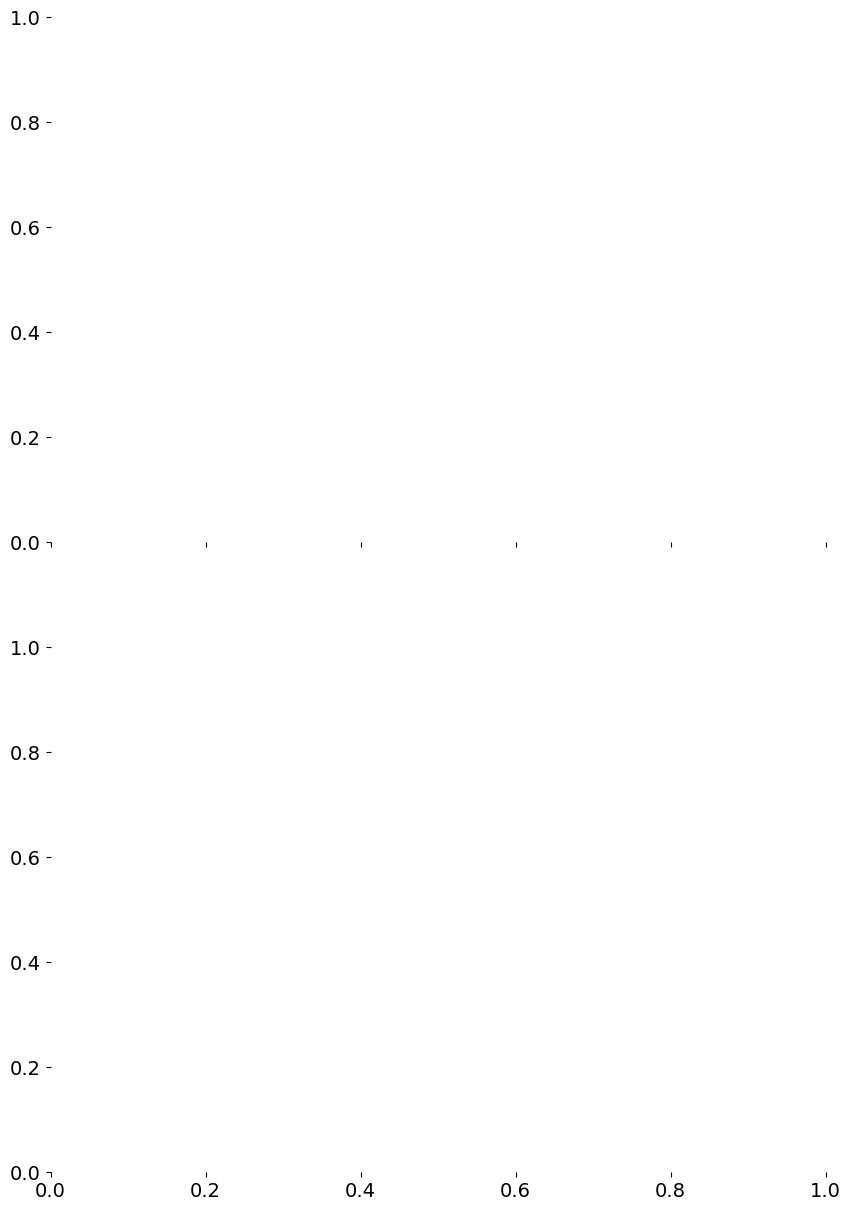

In [52]:
def plotting_continuious_reliability_diagram(results, model):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	for region in results.keys():
		predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
		actual = predictions['actual']
		predicted_mean = predictions['predicted_mean']
		predicted_std = predictions['predicted_std'].abs()

		standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
		cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
		for i in standard_error.index:
			cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

		ax[0].plot(x, cumulative_dist[:,0], label=region)
		ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

plotting_continuious_reliability_diagram(results, model='swmag')
plotting_continuious_reliability_diagram(results, model='twins')